<a href="https://colab.research.google.com/github/nando-cezar/pandora/blob/developer/pandora_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

> EM-DAT will be used, which is a global database that records information about natural and technological disasters. It is maintained by the Disaster Epidemiology Research Center (CRED) at the Catholic University of Louvain, Belgium. EM-DAT provides data on the occurrence, impact and response to disasters since the beginning of the 20th century.

> Data analysis will be separated by category and continental regions, namely:

*   Dry
*   Flood
*   Extreme temperature
*   Mist
*   Storm







# Importing libraries


In [34]:
!pip3 install opencage
!pip install openmeteo-requests
!pip install requests-cache retry-requests numpy pandas

In [35]:
import pandas as pd
from google.colab import drive
from time import sleep
import warnings
import requests
import json
from pandas import json_normalize
import seaborn as sns
from google.colab import userdata
import requests_cache
from retry_requests import retry

from opencage.geocoder import OpenCageGeocode
import openmeteo_requests




warnings.simplefilter("ignore")
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# EM-DAT: Reading the file


> Restricting reading to the following columns: location, start date and end date.

In [36]:
df = pd.read_excel(f"{userdata.get('notebook_path')}/{userdata.get('file_path')}.xlsx", sheet_name=[0, "EM-DAT Data"], usecols='K, N, Z, AA, AB, AC, AD, AE')

# EM-DAT: File handling


> Performing row removal with NaN

In [37]:
_data_type = {'Country': str, 'Location': str, 'Start Year': int, 'Start Month': int, 'Start Day': int, 'End Year': int, 'End Month': int, 'End Day': int}
df = df['EM-DAT Data'].fillna(0).astype(_data_type)

## EM-DAT: Data visualization without processing

In [38]:
display(df)

Country                                           Location  \
0       Bolivia                    Cochabamba, Santa Cruz, La Paz    
1     Argentina       Buenos Aires, Sante Fe, Formosa, Santa Cruz    
2       Uruguay                               Paysandu, Maldonado    
3         Chile  Antofagasta, Araucania, Arica y Parinacota, At...   
4        Brazil                              Porto Alegre district   
5      Paraguay  Alto Paraguay, Alto Parana, Amambay, Boqueron,...   
6        Mexico                                 Chihuahua province   
7     Argentina  Chubut, Neuquen, Rio Negro, Catamarca, Buenos ...   
8      Bolivia                  La Paz, Oruro, Cochabamba, Potosi    
9     Guatemala  El Progreso, Jalapa, Chiquimula, Zacapa, Jutiapa    
10    Argentina  Catamarca, Chaco, Corrientes, Formosa, Jujuy, ...   
11        Chile  Aisen del General Carlos Ibañez del Campo, Ant...   
12       Mexico  Chihuahua, Sonora, Baja California, Baja Calif...   
13         Peru  Ayacucho, Huancavelica, Tacna, Moquegua, Arequ...   
14       Mexico  Chihuahua, Puebla, Nuevo Leon, Hidalgo, Sonora...   
15    Argentina                                 Mar del Plata city   
16       Brazil                            Santa Catarina, Parana    
17        Chile  Aisen del General Carlos Ibañez del Campo, Ant...   
18         Peru  Ancash, Puno, Cusco, Arequipa, Moquegua, Tacna...   
19     Paraguay  Alto Paraguay, Alto Parana, Amambay, Boqueron,...   
20      Uruguay                                        Montevideo    
21       Mexico                                         Chihuahua    
22    Guatemala  Alta Verapaz, Baja Verapaz, Chimaltenango, Chi...   
23       Mexico  Aguascalientes, Baja California, Baja Californ...   
24  El Salvador                              Santa Tecla district    
25         Peru  Amazonas, Ancash, Apurimac, Arequipa, Ayacucho...   
26    Argentina  Buenos Aires, Buenos Aires D.f., Catamarca, Ch...   
27      Bolivia                                Santa Cruz province   
28        Chile   Aisen del Gral. Carlos Ibañez del Campo province   
29     Paraguay  Alto Paraguay, Alto Parana, Amambay, Boqueron,...   
30      Uruguay  Artigas, Canelones, Cerro Largo, Colonia, Dura...   
31         Peru  Ancash, Apurimac, Arequipa, Ayacucho, Cusco, H...   
32       Mexico                       Sinaloa, Sonora, Tamaulipas    
33         Peru  Huancavelica, Cusco, Ayacucho, Arequipa, Moque...   
34    Guatemala  Huehuetenango, Quiche, San Marcos, Solola, Que...   
35         Peru                                          Arequipa    
36         Peru  Amazonas, Ancash, Apurimac, Arequipa, Ayacucho...   
37         Peru  Apurimac, Arequipa, Cusco, Huancavelica, Lima,...   

    Start Year  Start Month  Start Day  End Year  End Month  End Day  
0         2000            7          0      2000          7        0  
1         2000            6         17      2000          6       17  
2         2000            7          0      2000          7        0  
3         2000            7          3      2000          7        3  
4         2000            7          0      2000          7        0  
5         2000            7          0      2000          7        0  
6         2000           10          0      2000         10        0  
7         2001            7          0      2001          7        0  
8         2001            7          0      2001          7        0  
9         2001           11          0      2001         11        0  
10        2002            7          0      2002          7        0  
11        2002            7          0      2002          7        0  
12        2002           12         24      2002         12       24  
13        2003            7          7      2003          8       15  
14        2003           12          0      2003         12        0  
15        2004            7          0      2004          7        0  
16        2004            7          0      2004          7        0  

# Treatment: Algorithms for data processing and structure assembly

> Algorithm for processing data (Formatting date for the api model)



In [39]:
def date_format_API(date):
  return "-".join([str(int(item)).zfill(2) if isinstance(item, float) else str(item).zfill(2) for item in date])

> Algorithm for boxplot graph plating

In [40]:
def generate_bsplot(dataTable, title, xlabel, ylabel="Monitoring variables", width=20, heigth=5, boxplot_width=.4, stripplot_size=3):

    ax = sns.boxplot(data=dataTable, width=boxplot_width, orient='h', color=".8", linewidth=1.5, medianprops={"color": "r", "linewidth": 1})
    ax = sns.stripplot(data=dataTable, orient='h', size=stripplot_size)
    ax.figure.set_size_inches(width, heigth)

    ax.set_title(title, fontsize=15)
    ax.set_xlabel(f"Range of values ({xlabel})", fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=45)
    ax.grid()
    ax

> Algorithm for switch value

In [41]:
def switch_value(source, offset, target):
    return target if source == offset else source

> Algorithm for locality accuracy

In [42]:
def get_index(target, source, label):
    for index, item in enumerate(source):
        if target.strip() == item[label]:
            return index
    return 0

# OPEN CAGE GEOCODE: Load latitude and longitude information from API

> Algorithm for processing data (Search latitude and longitude from location)

In [43]:
geocoder = OpenCageGeocode(userdata.get('api_key_opencage_geocode'))

def search_location(query):
    response = geocoder.geocode(query)
    return response

> Getting information and formatting dataframe


In [44]:
_locale_structure = []

def get_location_info(text_country, location):
    location_join = ", ".join([location, text_country])

    # Check if the location has been searched before
    for item in _locale_structure:
        if item['Location'] == location_join:
            return item

    result = search_location(query=location_join)
    if result:
        index = get_index(target=location_join, source=result, label="formatted")
        if index > -1:
            location_info = {
                'Location': location_join,
                'Latitude': result[index]["geometry"]["lat"],
                'Longitude': result[index]["geometry"]["lng"]
            }
            return location_info

    return None

def process_location_info(infos):
    start_day = switch_value(infos['Start Day'], 0, 1)
    end_day = switch_value(infos['End Day'], 0, 30)
    start_date = [infos['Start Year'], infos['Start Month'], start_day]
    end_date = [infos['End Year'], infos['End Month'], end_day]

    rdf = infos["Location"].split(',')

    if rdf:
        for location in rdf:
            location_info = get_location_info(infos["Country"], location.strip())
            if location_info and location_info["Location"] != infos["Country"]:
                location_info.update({'Start Date': start_date, 'End Date': end_date})
                _locale_structure.append(location_info)

for _, infos in df.iterrows():
    process_location_info(infos)

## OPEN CAGE GEOCODE: Data visualization without processing

In [45]:
_data_type = {'Location': str, 'Latitude': str, 'Longitude': str, 'Start Date': object, 'End Date': object}
df = pd.DataFrame(_locale_structure).astype(_data_type)
display(df)

Location     Latitude    Longitude     Start Date  \
0        Cochabamba, Bolivia  -17.3330142  -65.5010931   [2000, 7, 1]   
1        Santa Cruz, Bolivia   -17.333333        -61.5   [2000, 7, 1]   
2            La Paz, Bolivia        -15.0   -68.333333   [2000, 7, 1]   
3    Buenos Aires, Argentina  -37.1498403  -60.1319456   [2010, 7, 1]   
4        Sante Fe, Argentina  -39.0209899  -67.5588859  [2000, 6, 17]   
..                       ...          ...          ...            ...   
333           Moquegua, Peru   -16.833333   -70.916667   [2015, 5, 1]   
334              Pasco, Peru        -10.5       -75.25   [2015, 5, 1]   
335               Puno, Peru        -15.0        -70.0   [2015, 5, 1]   
336              Tacna, Peru   -17.666667   -70.333333   [2015, 5, 1]   
337           Ayucucho, Peru  -13.1571849  -74.2183383   [2015, 5, 1]   

          End Date  
0    [2000, 7, 30]  
1    [2000, 7, 30]  
2    [2000, 7, 30]  
3    [2010, 7, 30]  
4    [2000, 6, 17]  
..             ...  
333  [2015, 9, 30]  
334  [2015, 9, 30]  
335  [2015, 9, 30]  
336  [2015, 9, 30]  
337  [2015, 9, 30]  

[338 rows x 5 columns]

#OPEN-METEO: Load weather information from API



> Algorithm for processing data (Search weather from latitude and longitude)


In [46]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

def search_info_weather(latitude, longitude, start_date, end_date):
    start_date = date_format_API(date=start_date)
    end_date = date_format_API(date=end_date)
    params = {
	"latitude": latitude,
	"longitude": longitude,
	"start_date": start_date,
	"end_date": end_date,
	"daily": [
        "temperature_2m_max",
        "temperature_2m_min",
        "temperature_2m_mean",
        "apparent_temperature_max",
        "apparent_temperature_min",
        "apparent_temperature_mean",
        "precipitation_sum",
        "rain_sum",
        "snowfall_sum",
        "precipitation_hours",
        "wind_speed_10m_max",
        "wind_gusts_10m_max",
        "wind_direction_10m_dominant",
        "shortwave_radiation_sum",
        "et0_fao_evapotranspiration"
        ],
    "timezone": "GMT"
    }

    responses = openmeteo.weather_api(userdata.get('api_url_openmeteo'), params=params)

    # Process first location. Add a for-loop for multiple locations or weather models
    response = responses[0]

    # Process daily data. The order of variables needs to be the same as requested.
    daily = response.Daily()
    daily_temperature_2m_max = daily.Variables(0).ValuesAsNumpy()
    daily_temperature_2m_min = daily.Variables(1).ValuesAsNumpy()
    daily_temperature_2m_mean = daily.Variables(2).ValuesAsNumpy()
    daily_apparent_temperature_max = daily.Variables(3).ValuesAsNumpy()
    daily_apparent_temperature_min = daily.Variables(4).ValuesAsNumpy()
    daily_apparent_temperature_mean = daily.Variables(5).ValuesAsNumpy()
    daily_precipitation_sum = daily.Variables(6).ValuesAsNumpy()
    daily_rain_sum = daily.Variables(7).ValuesAsNumpy()
    daily_snowfall_sum = daily.Variables(8).ValuesAsNumpy()
    daily_precipitation_hours = daily.Variables(9).ValuesAsNumpy()
    daily_wind_speed_10m_max = daily.Variables(10).ValuesAsNumpy()
    daily_wind_gusts_10m_max = daily.Variables(11).ValuesAsNumpy()
    daily_wind_direction_10m_dominant = daily.Variables(12).ValuesAsNumpy()
    daily_shortwave_radiation_sum = daily.Variables(13).ValuesAsNumpy()
    daily_et0_fao_evapotranspiration = daily.Variables(14).ValuesAsNumpy()

    daily_data = {"date": pd.date_range(
        start = pd.to_datetime(daily.Time(), unit = "s"),
        end = pd.to_datetime(daily.TimeEnd(), unit = "s"),
        freq = pd.Timedelta(seconds = daily.Interval()),
        inclusive = "left"
    )}
    daily_data["latitude"] = response.Latitude()
    daily_data["longitude"] = response.Longitude()
    daily_data["temperature_2m_max"] = daily_temperature_2m_max
    daily_data["temperature_2m_min"] = daily_temperature_2m_min
    daily_data["temperature_2m_mean"] = daily_temperature_2m_mean
    daily_data["apparent_temperature_max"] = daily_apparent_temperature_max
    daily_data["apparent_temperature_min"] = daily_apparent_temperature_min
    daily_data["apparent_temperature_mean"] = daily_apparent_temperature_mean
    daily_data["precipitation_sum"] = daily_precipitation_sum
    daily_data["rain_sum"] = daily_rain_sum
    daily_data["snowfall_sum"] = daily_snowfall_sum
    daily_data["precipitation_hours"] = daily_precipitation_hours
    daily_data["wind_speed_10m_max"] = daily_wind_speed_10m_max
    daily_data["wind_gusts_10m_max"] = daily_wind_gusts_10m_max
    daily_data["wind_direction_10m_dominant"] = daily_wind_direction_10m_dominant
    daily_data["shortwave_radiation_sum"] = daily_shortwave_radiation_sum
    daily_data["et0_fao_evapotranspiration"] = daily_et0_fao_evapotranspiration

    return daily_data

> Getting information and formatting dataframe

In [47]:
#restruturar chamada de serviço para novo modelo
_weather_structure = []
for i, infos in df.iterrows():
  _info = search_info_weather(
      latitude=infos['Latitude'],
      longitude=infos['Longitude'],
      start_date=infos['Start Date'],
      end_date=infos['End Date']
      )
  _weather_structure.append(_info)

##OPEN-METEO: Data visualization without processing

In [48]:
df = pd.DataFrame(data = _weather_structure)
display(df)

date   latitude  longitude  \
0    DatetimeIndex(['2000-07-01', '2000-07-02', '20... -17.328648 -65.462433   
1    DatetimeIndex(['2000-07-01', '2000-07-02', '20... -17.328648 -61.473999   
2    DatetimeIndex(['2000-07-01', '2000-07-02', '20... -15.008787 -68.319305   
3    DatetimeIndex(['2010-07-01', '2010-07-02', '20... -37.152901 -60.119049   
4    DatetimeIndex(['2000-06-17'], dtype='datetime6... -39.050968 -67.530853   
..                                                 ...        ...        ...   
333  DatetimeIndex(['2015-05-01', '2015-05-02', '20... -16.836555 -70.966492   
334  DatetimeIndex(['2015-05-01', '2015-05-02', '20... -10.509665 -75.251099   
335  DatetimeIndex(['2015-05-01', '2015-05-02', '20... -15.008787 -70.084015   
336  DatetimeIndex(['2015-05-01', '2015-05-02', '20... -17.680141 -70.309784   
337  DatetimeIndex(['2015-05-01', '2015-05-02', '20... -13.181019 -74.247955   

                                    temperature_2m_max  \
0    [16.5645, 16.7645, 13.014501, 14.4645, 14.9145...   
1    [31.8735, 30.573502, 23.6235, 26.7735, 30.6735...   
2    [1.7364998, 1.4365005, -3.0634995, -1.6135006,...   
3    [14.752501, 14.752501, 17.3525, 19.6525, 16.75...   
4                                          [4.9989996]   
..                                                 ...   
333  [19.6215, 19.5215, 19.7215, 19.7215, 20.3215, ...   
334  [21.4225, 22.522501, 21.8225, 20.772501, 21.62...   
335  [12.910501, 13.660501, 13.8605, 14.0105, 13.41...   
336  [21.714, 21.764, 21.814001, 22.114, 21.914, 22...   
337  [16.7475, 18.6975, 18.8475, 18.5975, 17.5975, ...   

                                    temperature_2m_min  \
0    [10.6645, 9.1645, 9.7145, 8.6645, 5.5645, 6.46...   
1    [24.473501, 21.5235, 18.073502, 16.6235, 16.72...   
2    [-6.0135, -7.4135, -7.8635006, -8.863501, -11....   
3    [6.8025002, 7.3525, 12.002501, 13.8025, 9.6525...   
4                                             [-3.201]   
..                                                 ...   
333  [9.271501, 8.4715, 7.9715, 4.6715, 5.8715, 11....   
334  [16.1725, 16.3725, 17.022501, 16.8225, 16.0725...   
335  [3.7605002, 0.81049997, 2.5605001, 2.2105, 1.9...   
336  [14.864, 14.964001, 14.4140005, 12.214001, 14....   
337  [11.1975, 9.4975, 7.8975, 10.797501, 10.7475, ...   

                                   temperature_2m_mean  \
0    [13.249917, 13.099917, 11.343667, 11.262417, 1...   
1    [27.494331, 25.97558, 20.140167, 21.086, 23.18...   
2    [-3.096834, -3.234334, -5.5301666, -5.8197513,...   
3    [9.535833, 10.3879175, 13.727501, 16.087915, 1...   
4                                          [0.4698334]   
..                                                 ...   
333  [14.969415, 14.248581, 14.369418, 12.469417, 1...   
334  [18.080835, 18.637083, 18.601664, 18.068333, 1...   
335  [7.5771675, 6.581333, 8.066751, 8.368833, 7.98...   
336  [17.728586, 17.566086, 17.422333, 17.157751, 1...   
337  [13.514167, 13.77875, 13.347501, 14.078751, 13...   

                              apparent_temperature_max  \
0    [16.21975, 16.977562, 12.0958, 14.070719, 15.0...   
1    [31.236206, 31.622204, 23.155787, 28.12455, 32...   
2    [-1.6147358, -2.0621822, -6.456402, -5.575929,...   
3    [11.289698, 13.687119, 16.819235, 18.045315, 1...   
4                                           [1.095437]   
..                                                 ...   
333  [20.110523, 19.240551, 18.904837, 19.067566, 1...   
334  [23.381104, 25.385616, 24.49458, 23.053028, 25...   
335  [11.439516, 11.17636, 12.007843, 12.862324, 11...   
336  [21.679295, 21.320292, 21.60883, 21.198029, 20...   
337  [16.423504, 18.820051, 19.090342, 19.133211, 1...   

                              apparent_temperature_min  \
0    [9.828032, 8.41754, 8.819005, 7.598031, 3.3945...   
1    [25.691208, 20.89247, 15.9091, 15.763752, 18.2...   
2    [-9.542122, -11.071316, -11.609158, -12.46461,...   
3    [3.00781, 5.7986507, 11.404603, 12.561686, 6.8...   
4          

## Reorganization of daily information structure

In [49]:
columns_to_explode = [
    'date',
    'temperature_2m_max',
    'temperature_2m_min',
    'temperature_2m_mean',
    'apparent_temperature_max',
    'apparent_temperature_min',
    'apparent_temperature_mean',
    'precipitation_sum',
    'rain_sum',
    'snowfall_sum',
    'precipitation_hours',
    'wind_speed_10m_max',
    'wind_gusts_10m_max',
    'wind_direction_10m_dominant',
    'shortwave_radiation_sum',
    'et0_fao_evapotranspiration',
]

df = df.explode(columns_to_explode)


##OPEN-METEO: Data visualization daily information

In [50]:
_data_type = {
    'date': object,
    'temperature_2m_max': float,
    'temperature_2m_min': float,
    'temperature_2m_mean': float,
    'apparent_temperature_max': float,
    'apparent_temperature_min': float,
    'apparent_temperature_mean': float,
    'precipitation_sum': float,
    'rain_sum': float,
    'snowfall_sum': float,
    'precipitation_hours': float,
    'wind_speed_10m_max': float,
    'wind_gusts_10m_max': float,
    'wind_direction_10m_dominant': float,
    'shortwave_radiation_sum': float,
    'et0_fao_evapotranspiration': float,
    'latitude': str,
    'longitude': str
}

df = df.astype(_data_type)
display(df)

date             latitude           longitude  \
0    2000-07-01 00:00:00   -17.32864761352539  -65.46243286132812   
0    2000-07-02 00:00:00   -17.32864761352539  -65.46243286132812   
0    2000-07-03 00:00:00   -17.32864761352539  -65.46243286132812   
0    2000-07-04 00:00:00   -17.32864761352539  -65.46243286132812   
0    2000-07-05 00:00:00   -17.32864761352539  -65.46243286132812   
..                   ...                  ...                 ...   
337  2015-09-26 00:00:00  -13.181018829345703  -74.24795532226562   
337  2015-09-27 00:00:00  -13.181018829345703  -74.24795532226562   
337  2015-09-28 00:00:00  -13.181018829345703  -74.24795532226562   
337  2015-09-29 00:00:00  -13.181018829345703  -74.24795532226562   
337  2015-09-30 00:00:00  -13.181018829345703  -74.24795532226562   

     temperature_2m_max  temperature_2m_min  temperature_2m_mean  \
0             16.564501           10.664500            13.249917   
0             16.764500            9.164500            13.099917   
0             13.014501            9.714500            11.343667   
0             14.464500            8.664500            11.262417   
0             14.914500            5.564500            10.537417   
..                  ...                 ...                  ...   
337           18.897499           11.097501            14.278750   
337           19.847500           10.047501            14.643332   
337           19.147499           10.647500            13.839168   
337           18.997499            9.347501            13.412083   
337           18.447500           10.697500            13.687084   

     apparent_temperature_max  apparent_temperature_min  \
0                   16.219749                  9.828032   
0                   16.977562                  8.417540   
0                   12.095800                  8.819005   
0                   14.070719                  7.598031   
0                   15.059834                  3.394536   
..                        ...                       ...   
337                 18.443110                 10.589446   
337                 20.150736                  9.195742   
337                 19.766375                  9.929972   
337                 19.100431                  8.891299   
337                 19.085136                  9.911896   

     apparent_temperature_mean  precipitation_sum  rain_sum  snowfall_sum  \
0                    12.665357           9.599999  9.599999           0.0   
0                    12.729749           4.100000  4.100000           0.0   
0                    10.803290           7.400000  7.400000           0.0   
0                    10.627559           0.200000  0.200000           0.0   
0                     9.442414           0.100000  0.100000           0.0   
..                         ...                ...       ...           ...   
337                  13.644238           2.300000  2.300000           0.0   
337                  13.858916           1.700000  1.700000           0.0   
337                  13.115692           2.400000  2.400000           0.0   
337                  12.831300           1.000000  1.000000           0.0   
337                  13.027007           1.900000  1.900000           0.0   

     precipitation_hours  wind_speed_10m_max  wind_gusts_10m_max  \
0                   19.0           12.261158           43.199997   
0                   15.0            8.825508           33.480000   
0                   10.0            8.557102           28.440001   
0                    2.0            7.729527           28.440001   
0                    1.0            9.000000           33.480000   
..                   ...                 ...                 ...   
337                  8.0            6.696387           23.039999   
337                  3.0            8.396570           28.799999   
337                  4.0            7.636753           26.639999   
337                  4.0           10.195057           31.31

#Data analysis - Central Tendency Measures


## Mean

In [53]:
_data = df.groupby(['date']).mean()
display(_data)

temperature_2m_max  temperature_2m_min  temperature_2m_mean  \
date                                                                      
2000-06-17            4.999000           -3.201000             0.469833   
2000-07-01           18.452250            9.639750            13.253811   
2000-07-02           18.852250            8.839750            13.789749   
2000-07-03           12.139750            6.739750             9.188188   
2000-07-04           14.377250            5.264750             9.281416   
...                        ...                 ...                  ...   
2015-09-26           20.507241           12.293779            15.837208   
2015-09-27           21.378394           10.364933            15.723265   
2015-09-28           21.422625           11.182240            15.899708   
2015-09-29           21.004356           10.047625            15.418740   
2015-09-30           20.431279           10.616856            15.134764   

            apparent_temperature_max  apparent_temperature_min  \
date                                                             
2000-06-17                  1.095437                 -7.051040   
2000-07-01                 17.816040                  8.525884   
2000-07-02                 17.621701                  6.926876   
2000-07-03                 10.213009                  4.294214   
2000-07-04                 13.216083                  3.366018   
...                              ...                       ...   
2015-09-26                 20.641171                 11.351487   
2015-09-27                 21.843446                  8.584907   
2015-09-28                 21.659371                  9.551468   
2015-09-29                 20.957468                  8.119136   
2015-09-30                 20.240180                  8.920969   

            apparent_temperature_mean  precipitation_sum  rain_sum  \
date                                                                 
2000-06-17                  -3.242274           0.000000  0.000000   
2000-07-01                  12.423350           3.850000  3.850000   
2000-07-02                  12.693107           6.350000  6.350000   
2000-07-03                   7.124496           4.750000  4.750000   
2000-07-04                   7.709183           0.325000  0.325000   
...                               ...                ...       ...   
2015-09-26                  15.245033           4.909615  4.667307   
2015-09-27                  14.902778           4.061539  4.061539   
2015-09-28                  15.032970           3.523077  3.453846   
2015-09-29                  14.255341           2.234615  2.234615   
2015-09-30                  13.932792           3.496154  3.369231   

            snowfall_sum  precipitation_hours  wind_speed_10m_max  \
date                                                                
2000-06-17      0.000000             0.000000            9.227524   
2000-07-01      0.000000             7.000000           14.467812   
2000-07-02      0.000000             6.500000           18.470839   
2000-07-03      0.000000             5.750000           13.122940   
2000-07-04      0.000000             2.000000            8.906581   
...                  ...                  ...                 ...   
2015-09-26      0.169615             9.288462           10.779499   
2015-09-27      0.000000             5.942308           10.161220   
2015-09-28      0.048462             6.442308           10.842280   
2015-09-29      0.000000             3.538462           11.659640   
2015-09-30      0.088846             5.326923           11.419443   

            wind_gusts_10m_max  wind_direction_10m_dominant  \
date                                                          
2000-06-17           18.000000                   131.261169   
2000-07-01           39.059999                   194.213946   
2000-07-02           50.129998                   167.416516   
2000-07-03           29.969999                   147.

### Data visualization with processing

> Temperature

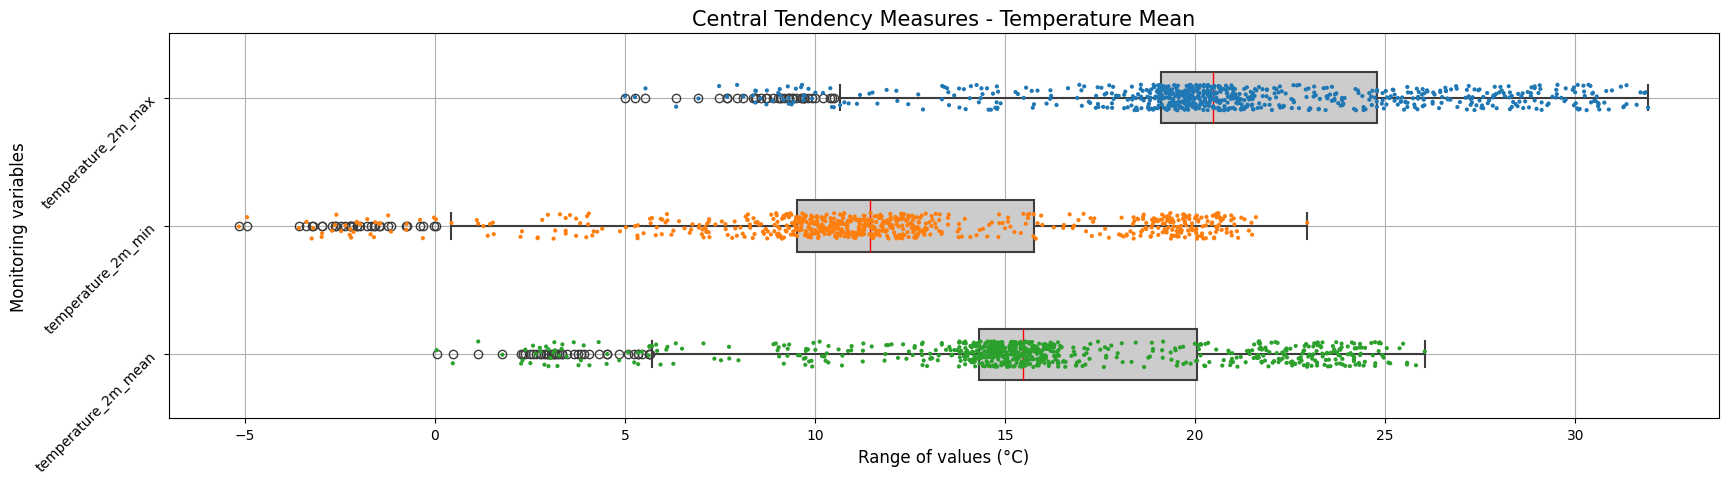

In [54]:
generate_bsplot(
    dataTable=_data[['temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean']],
    title="Central Tendency Measures - Temperature Mean",
    xlabel="°C"
    )

> Apparent Temperature

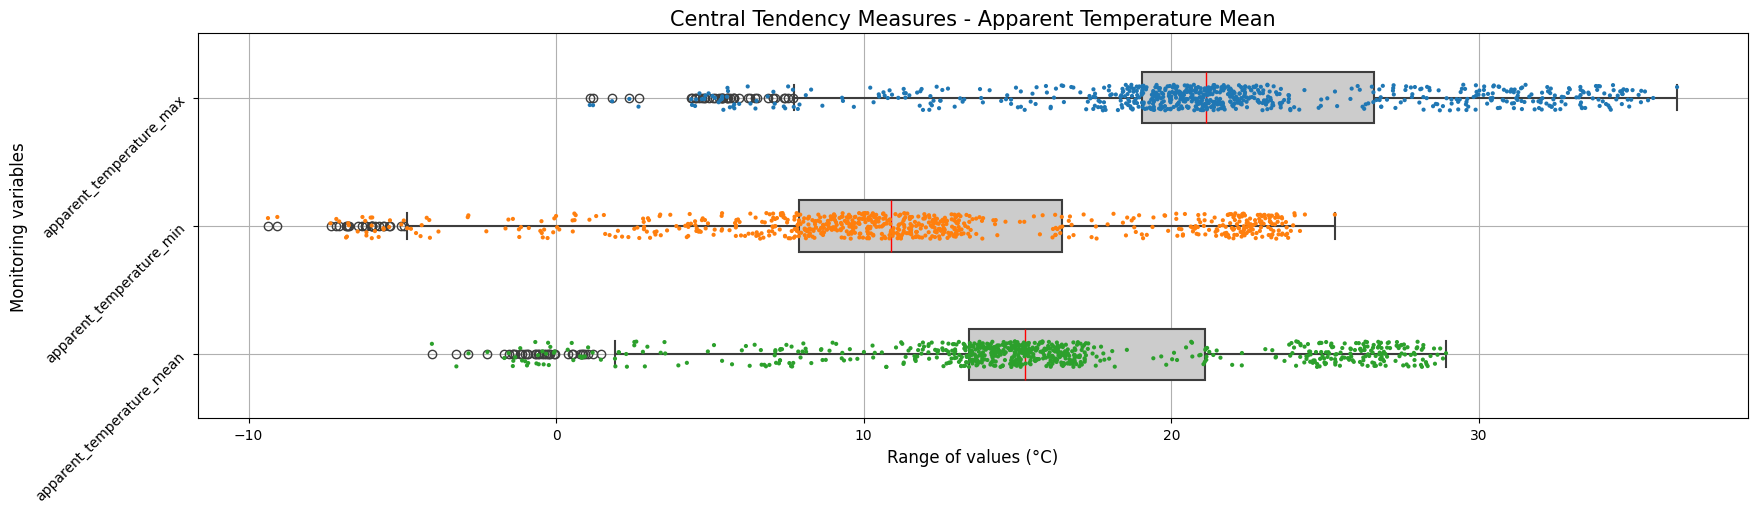

In [55]:
generate_bsplot(
    dataTable=_data[['apparent_temperature_max', 'apparent_temperature_min', 'apparent_temperature_mean']],
    title="Central Tendency Measures - Apparent Temperature Mean",
    xlabel="°C"
    )

> Precipitation and rain

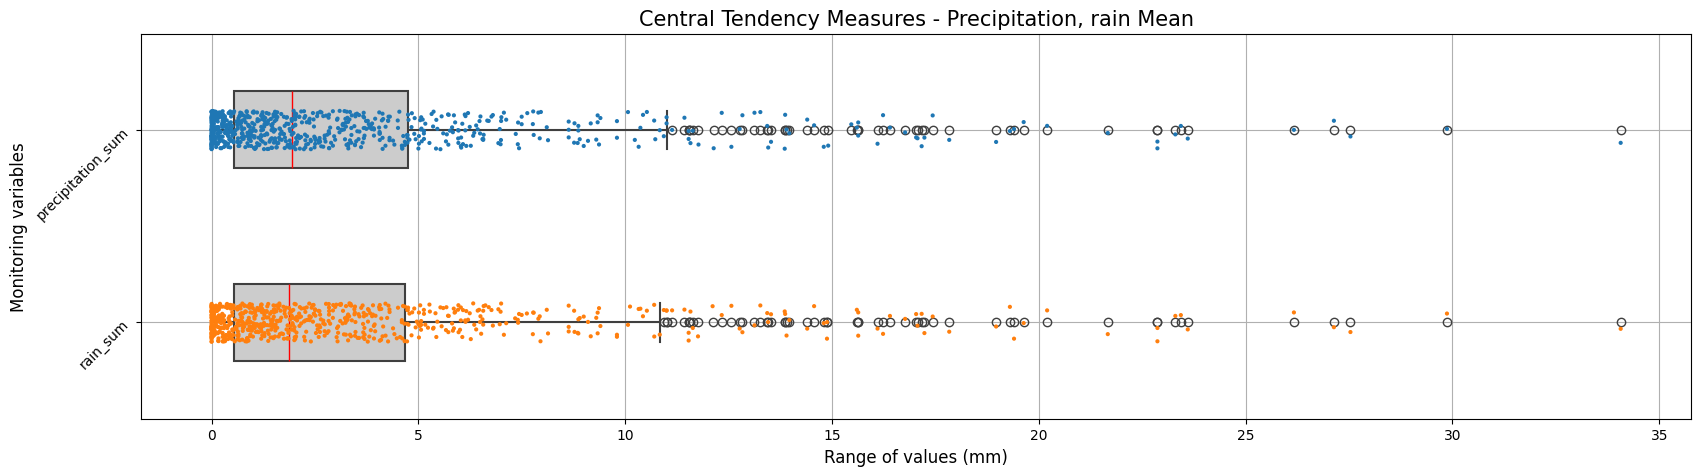

In [56]:
generate_bsplot(
    dataTable=_data[['precipitation_sum', 'rain_sum']],
    title="Central Tendency Measures - Precipitation, rain Mean",
    xlabel="mm"
    )

> Snowfall

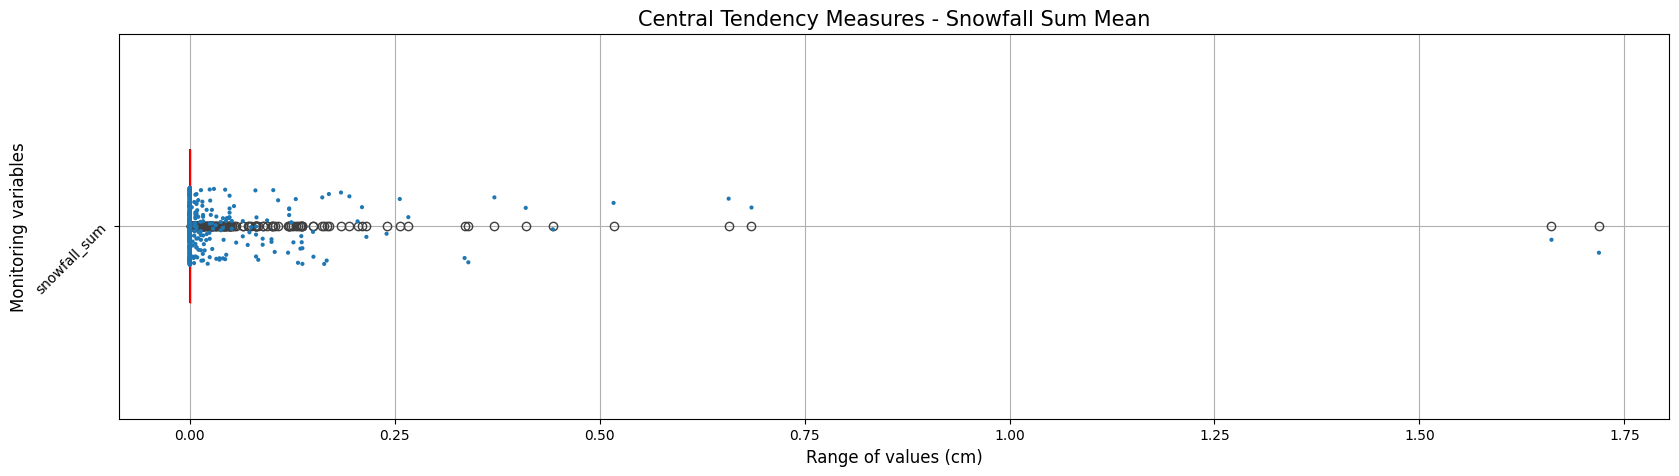

In [57]:
generate_bsplot(
    dataTable=_data[['snowfall_sum']],
    title="Central Tendency Measures - Snowfall Sum Mean",
    xlabel="cm"
    )

> Precipitation (h)

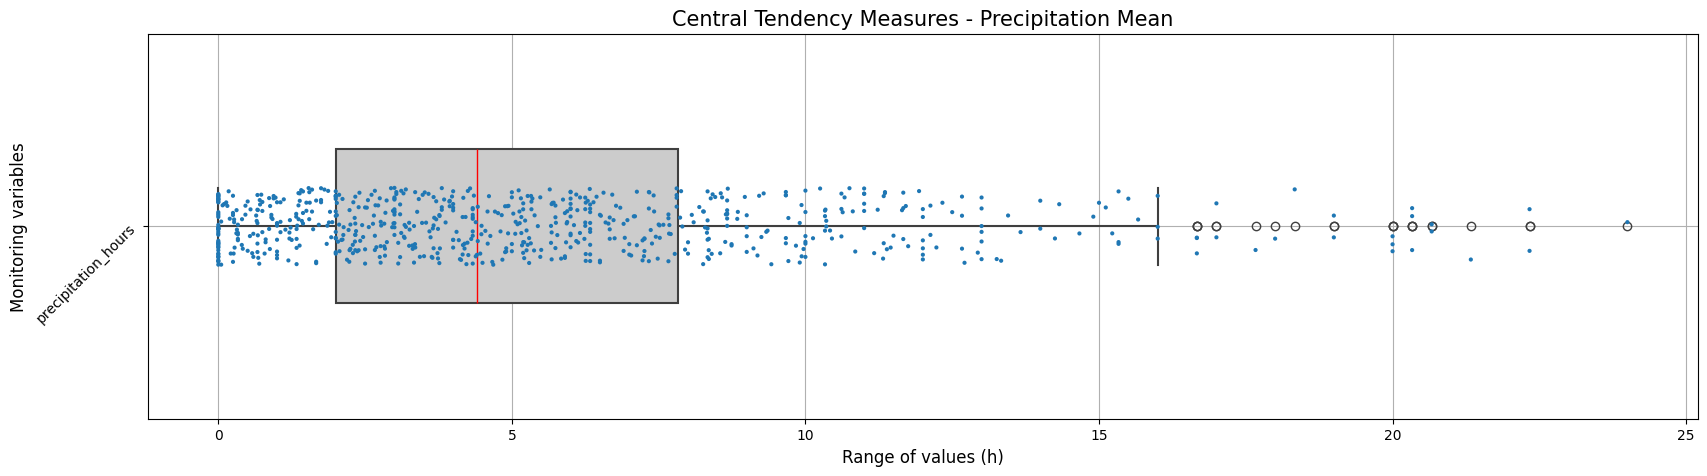

In [58]:
generate_bsplot(
    dataTable=_data[['precipitation_hours']],
    title="Central Tendency Measures - Precipitation Mean",
    xlabel="h"
    )

> Wind speed 10m

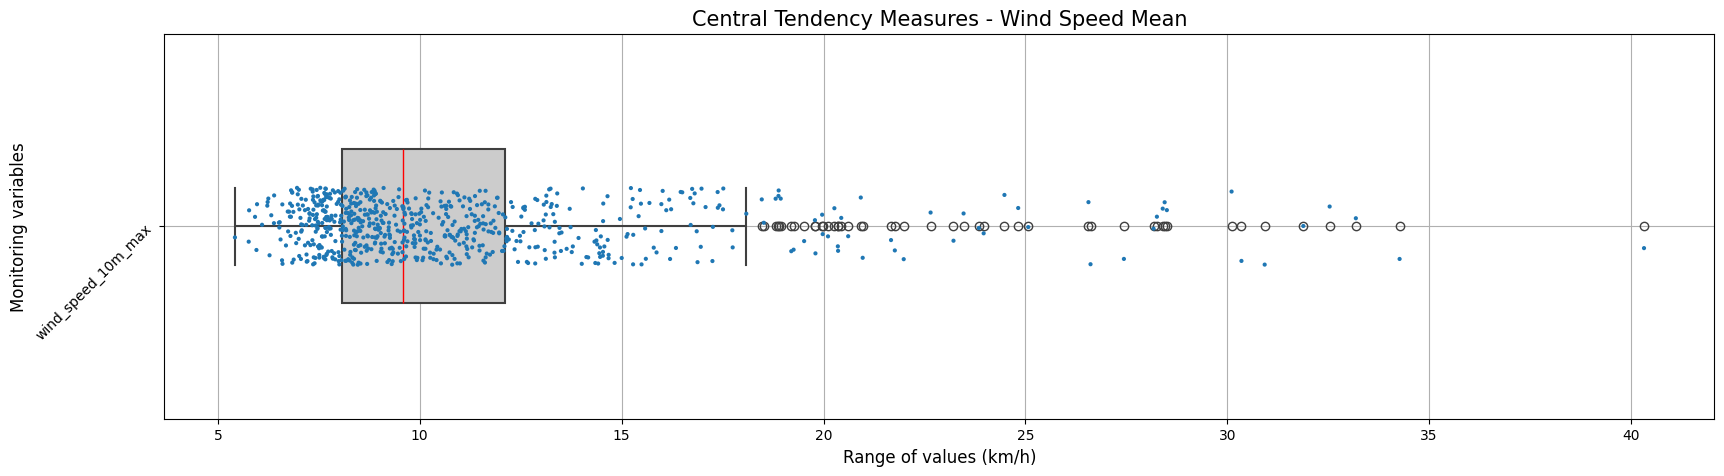

In [59]:
generate_bsplot(
    dataTable=_data[['wind_speed_10m_max']],
    title="Central Tendency Measures - Wind Speed Mean",
    xlabel="km/h"
    )

> Wind direction 10m

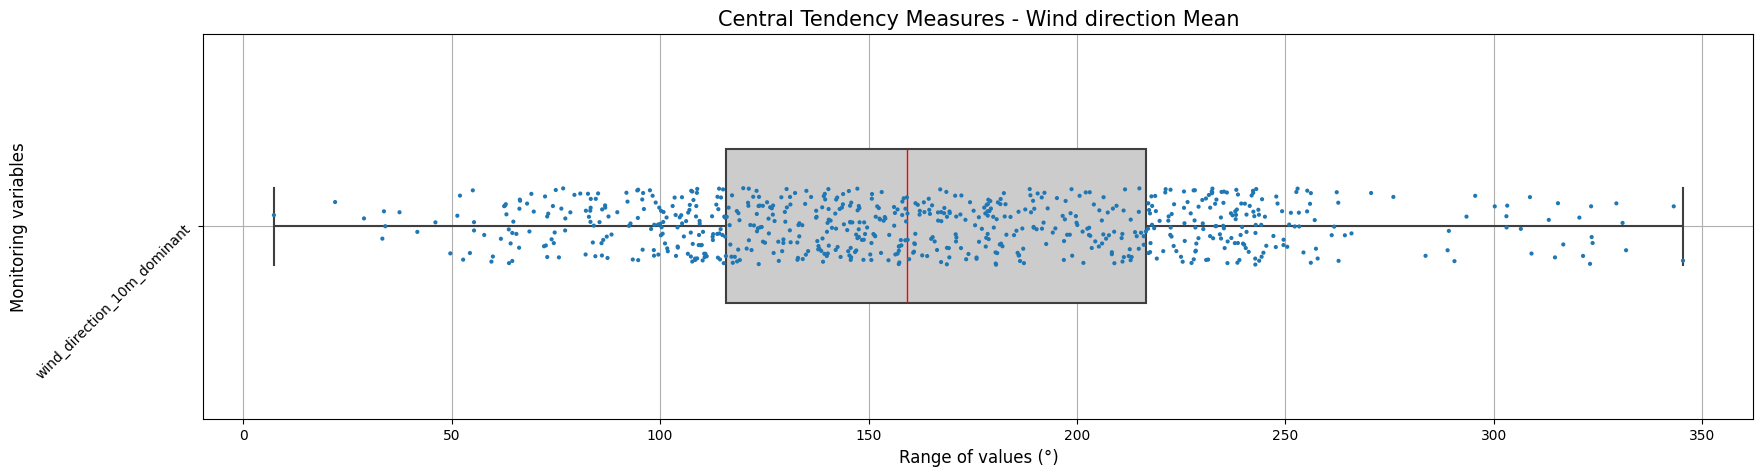

In [60]:
generate_bsplot(
    dataTable=_data[['wind_direction_10m_dominant']],
    title="Central Tendency Measures - Wind direction Mean",
    xlabel="°"
    )

> Shortware radiation sum

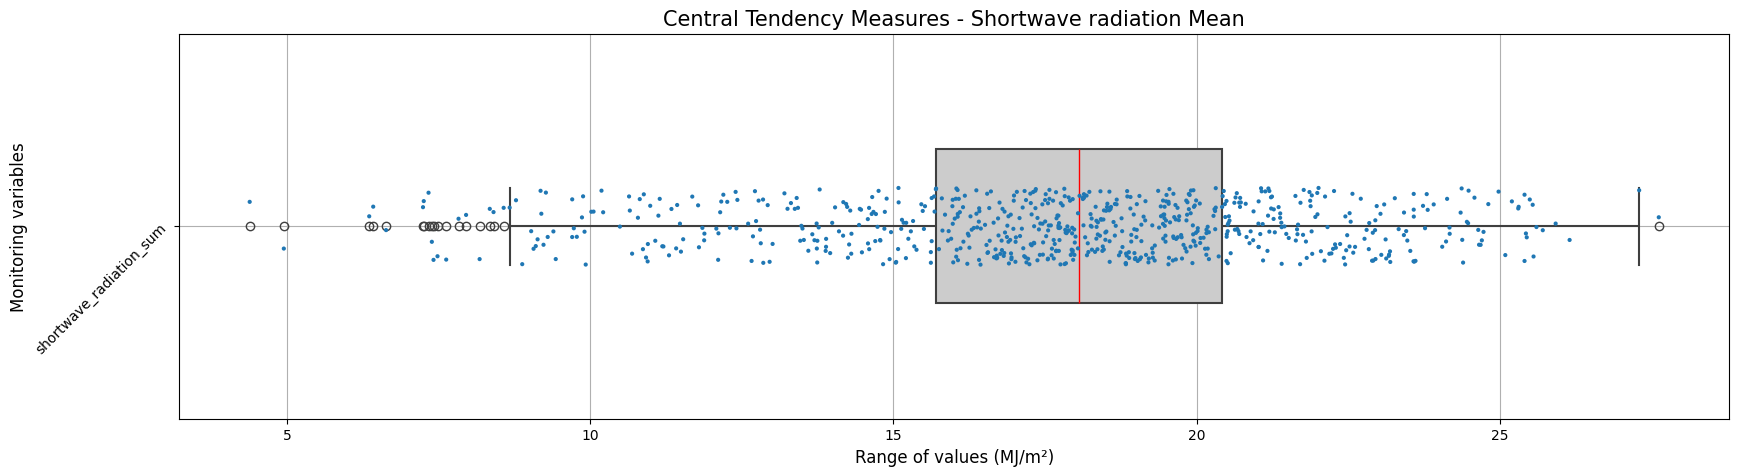

In [61]:
generate_bsplot(
    dataTable=_data[['shortwave_radiation_sum']],
    title="Central Tendency Measures - Shortwave radiation Mean",
    xlabel="MJ/m²"
    )

> Evapotranspiration

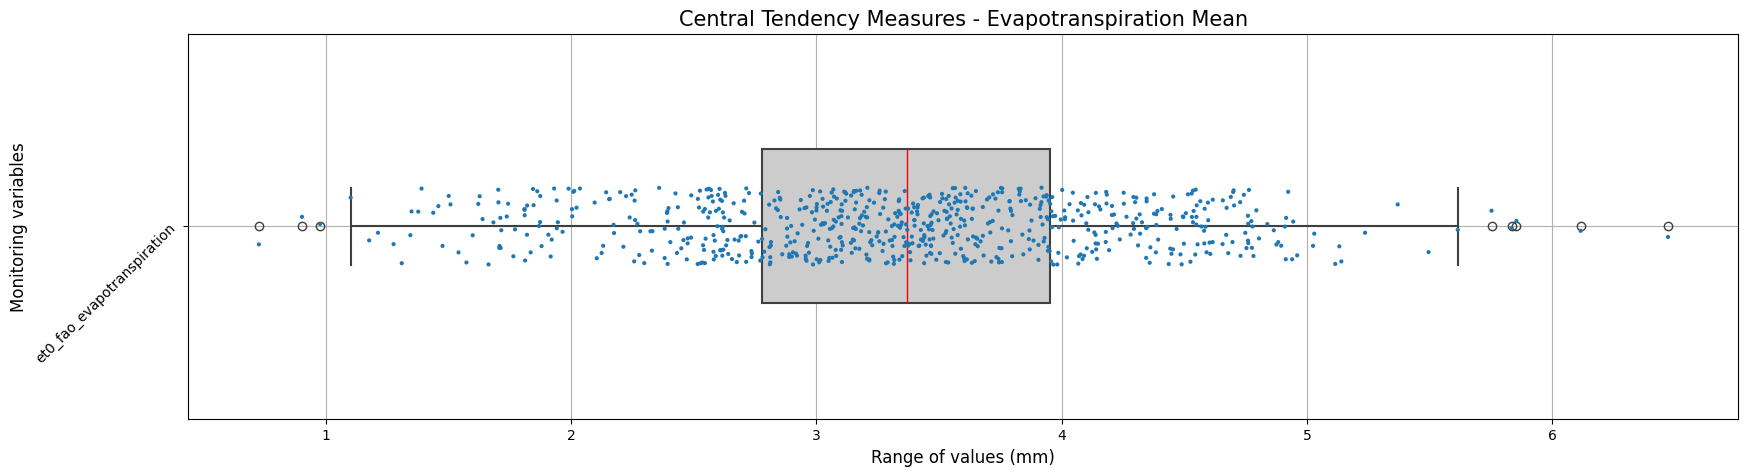

In [62]:
generate_bsplot(
    dataTable=_data[['et0_fao_evapotranspiration']],
    title="Central Tendency Measures - Evapotranspiration Mean",
    xlabel="mm"
    )

## Median

In [63]:
_data = df.groupby(['date']).median()
display(_data)

temperature_2m_max  temperature_2m_min  temperature_2m_mean  \
date                                                                      
2000-06-17            4.999000             -3.2010             0.469833   
2000-07-01           20.099500             10.0495            14.308874   
2000-07-02           21.699499             10.6245            16.208874   
2000-07-03           13.999500              8.3745            11.071375   
2000-07-04           16.174500              6.6495            10.929708   
...                        ...                 ...                  ...   
2015-09-26           20.014000             12.9495            16.134832   
2015-09-27           21.114000              8.8495            16.255747   
2015-09-28           21.549500             10.2215            17.049500   
2015-09-29           22.014000              9.3495            15.912000   
2015-09-30           20.349499              8.3995            14.851583   

            apparent_temperature_max  apparent_temperature_min  \
date                                                             
2000-06-17                  1.095437                 -7.051040   
2000-07-01                 20.821345                  8.977226   
2000-07-02                 20.463390                  8.943175   
2000-07-03                 12.076325                  6.438457   
2000-07-04                 15.157855                  5.082465   
...                              ...                       ...   
2015-09-26                 19.054529                 10.885975   
2015-09-27                 19.806551                  7.752422   
2015-09-28                 21.329945                  7.281966   
2015-09-29                 20.330042                  7.584077   
2015-09-30                 20.894489                  7.090716   

            apparent_temperature_mean  precipitation_sum  rain_sum  \
date                                                                 
2000-06-17                  -3.242274               0.00      0.00   
2000-07-01                  13.893473               2.90      2.90   
2000-07-02                  15.232708               5.35      5.35   
2000-07-03                   9.388843               3.70      3.70   
2000-07-04                   9.698092               0.10      0.10   
...                               ...                ...       ...   
2015-09-26                  14.408115               3.80      3.00   
2015-09-27                  14.898758               0.70      0.70   
2015-09-28                  14.262975               1.20      1.20   
2015-09-29                  14.004052               0.00      0.00   
2015-09-30                  14.304695               0.30      0.30   

            snowfall_sum  precipitation_hours  wind_speed_10m_max  \
date                                                                
2000-06-17           0.0                  0.0            9.227524   
2000-07-01           0.0                  4.5           11.710578   
2000-07-02           0.0                  5.5           15.924313   
2000-07-03           0.0                  5.0           12.537002   
2000-07-04           0.0                  1.0            8.630516   
...                  ...                  ...                 ...   
2015-09-26           0.0                 10.0           11.055113   
2015-09-27           0.0                  4.0           10.495713   
2015-09-28           0.0                  5.0           11.298495   
2015-09-29           0.0                  0.0           12.481153   
2015-09-30           0.0                  2.0           12.620554   

            wind_gusts_10m_max  wind_direction_10m_dominant  \
date                                                          
2000-06-17           18.000000                   131.261169   
2000-07-01           35.279998                   201.260082   
2000-07-02           45.180000                   173.045090   
2000-07-03           29.879999                   143.

### Data visualization with processing

> Temperature

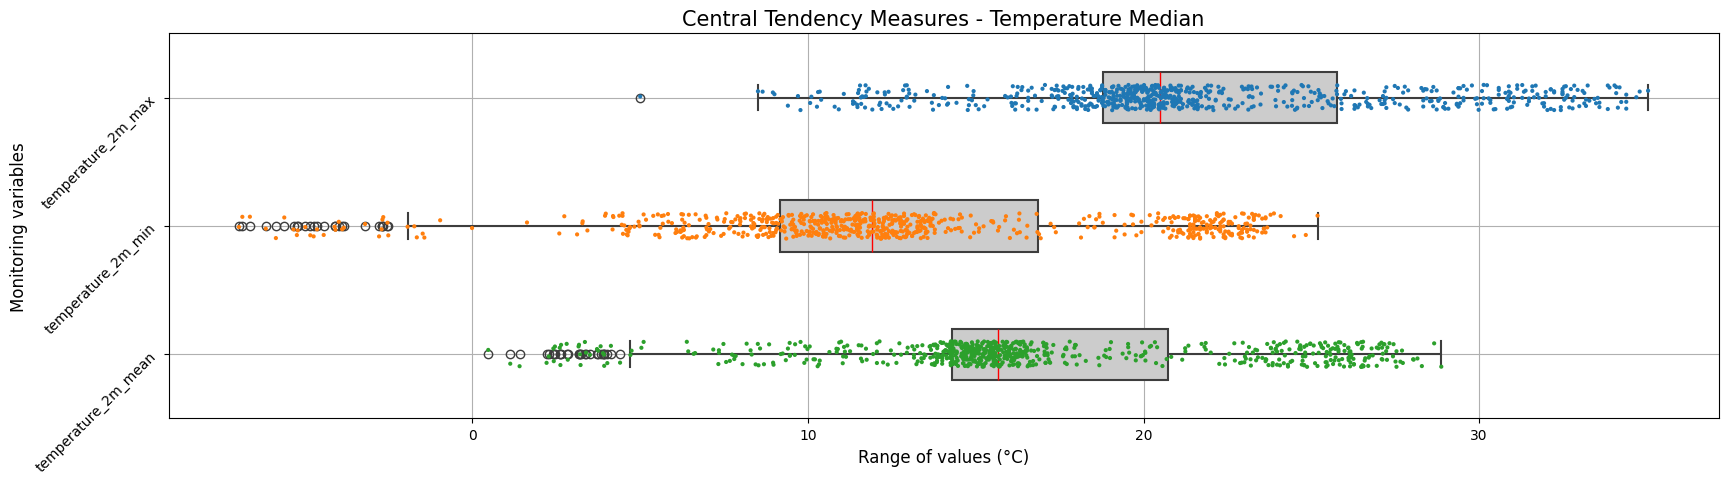

In [64]:
generate_bsplot(
    dataTable=_data[['temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean']],
    title="Central Tendency Measures - Temperature Median",
    xlabel="°C"
    )

> Apparent Temperature

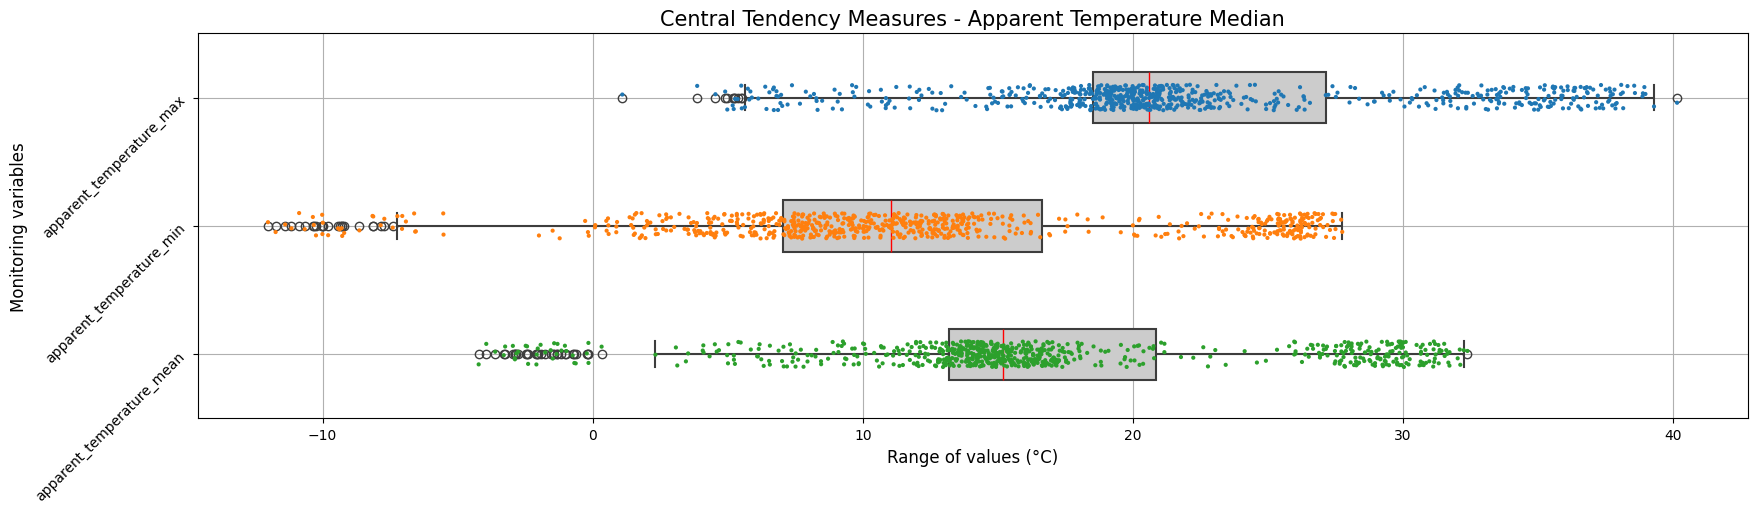

In [65]:
generate_bsplot(
    dataTable=_data[['apparent_temperature_max', 'apparent_temperature_min', 'apparent_temperature_mean']],
    title="Central Tendency Measures - Apparent Temperature Median",
    xlabel="°C"
    )

> Precipitation and rain

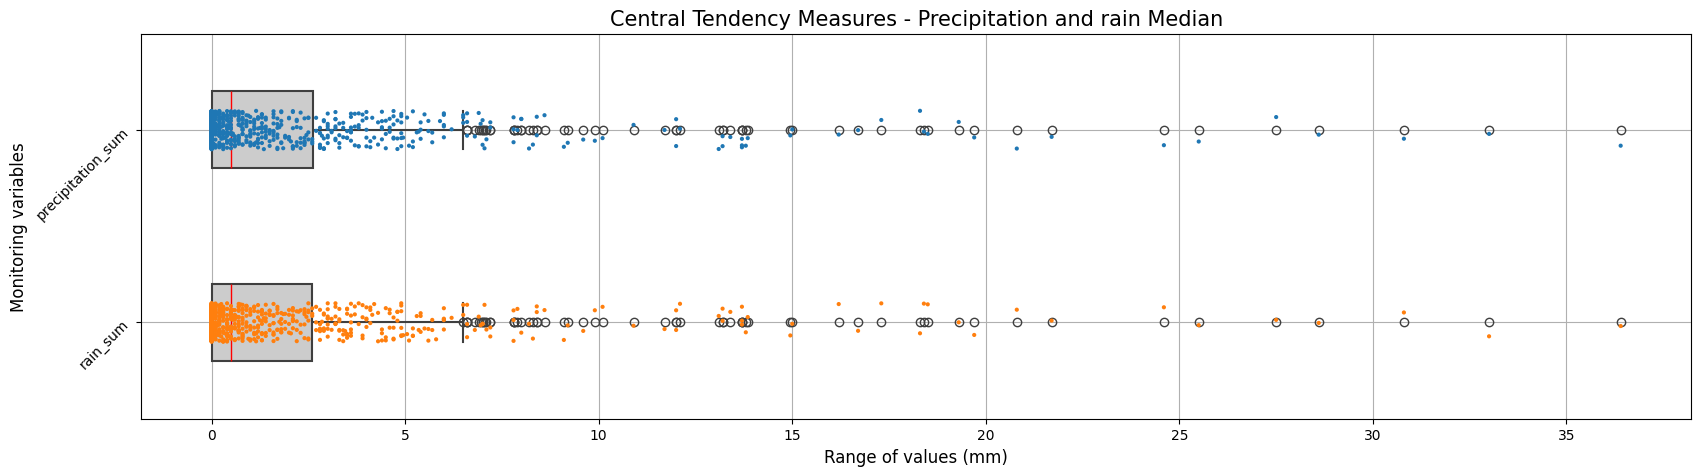

In [66]:
generate_bsplot(
    dataTable=_data[['precipitation_sum', 'rain_sum']],
    title="Central Tendency Measures - Precipitation and rain Median",
    xlabel="mm"
    )

> Snowfall

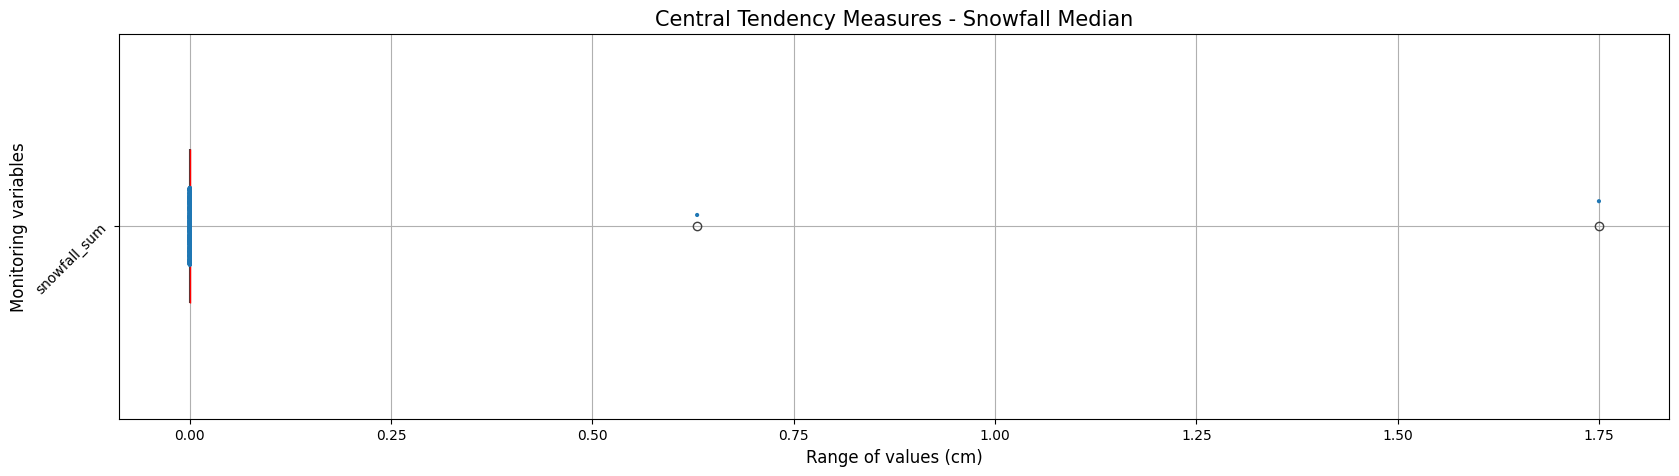

In [67]:
generate_bsplot(
    dataTable=_data[['snowfall_sum']],
    title="Central Tendency Measures - Snowfall Median",
    xlabel="cm"
    )

> Precipitation (h)

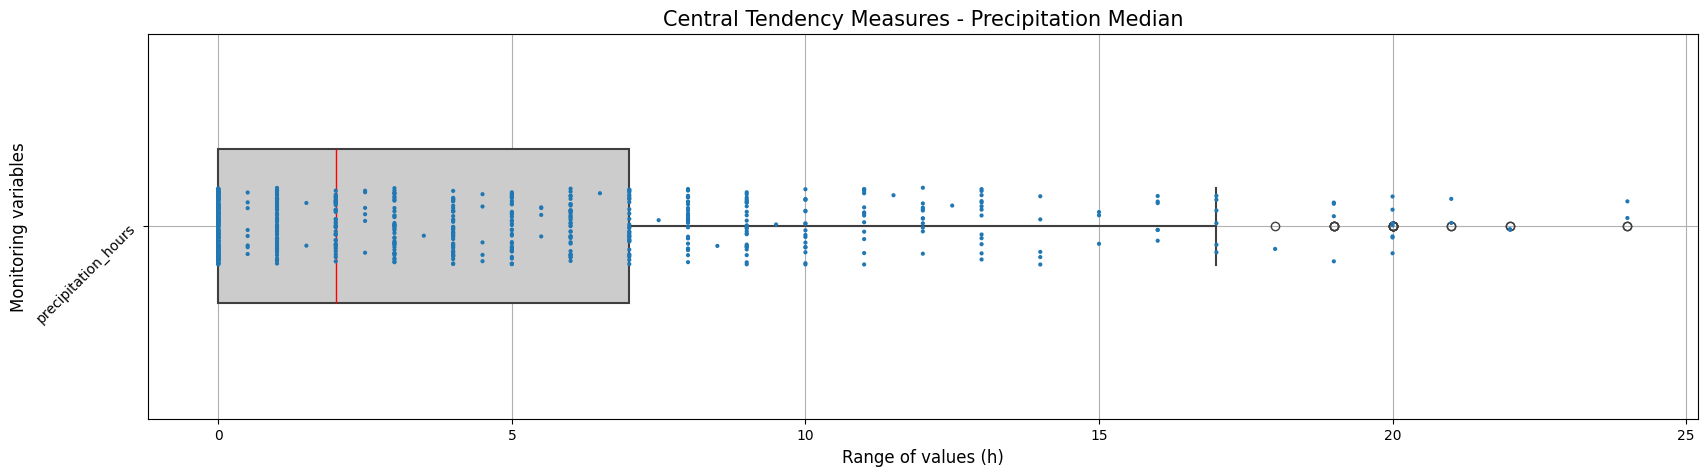

In [68]:
generate_bsplot(
    dataTable=_data[['precipitation_hours']],
    title="Central Tendency Measures - Precipitation Median",
    xlabel="h"
    )

> Wind speed 10m

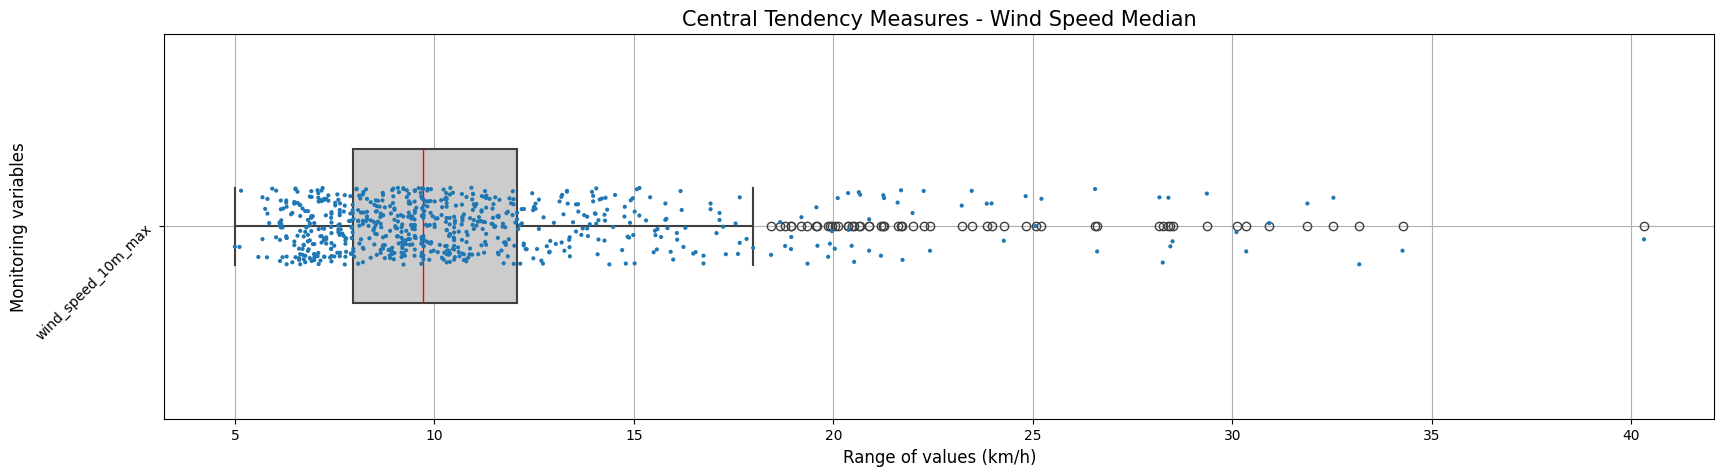

In [69]:
generate_bsplot(
    dataTable=_data[['wind_speed_10m_max']],
    title="Central Tendency Measures - Wind Speed Median",
    xlabel="km/h"
    )

> Wind direction 10m

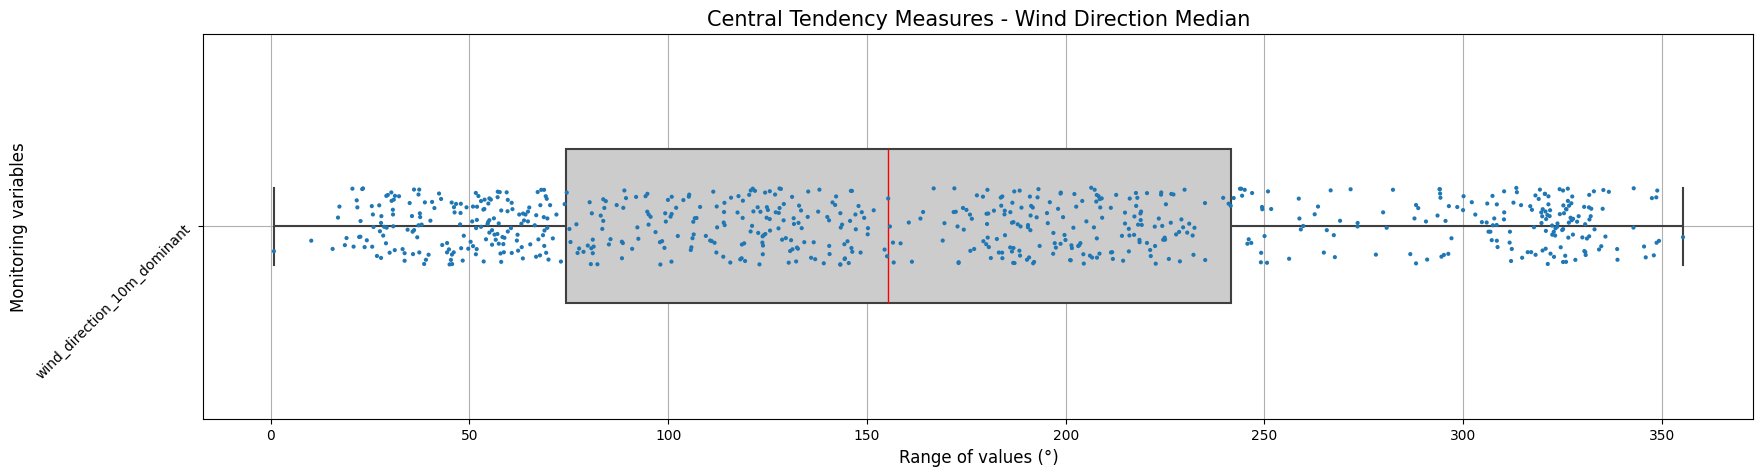

In [70]:
generate_bsplot(
    dataTable=_data[['wind_direction_10m_dominant']],
    title="Central Tendency Measures - Wind Direction Median",
    xlabel="°"
    )

> Shortwave radiation sum

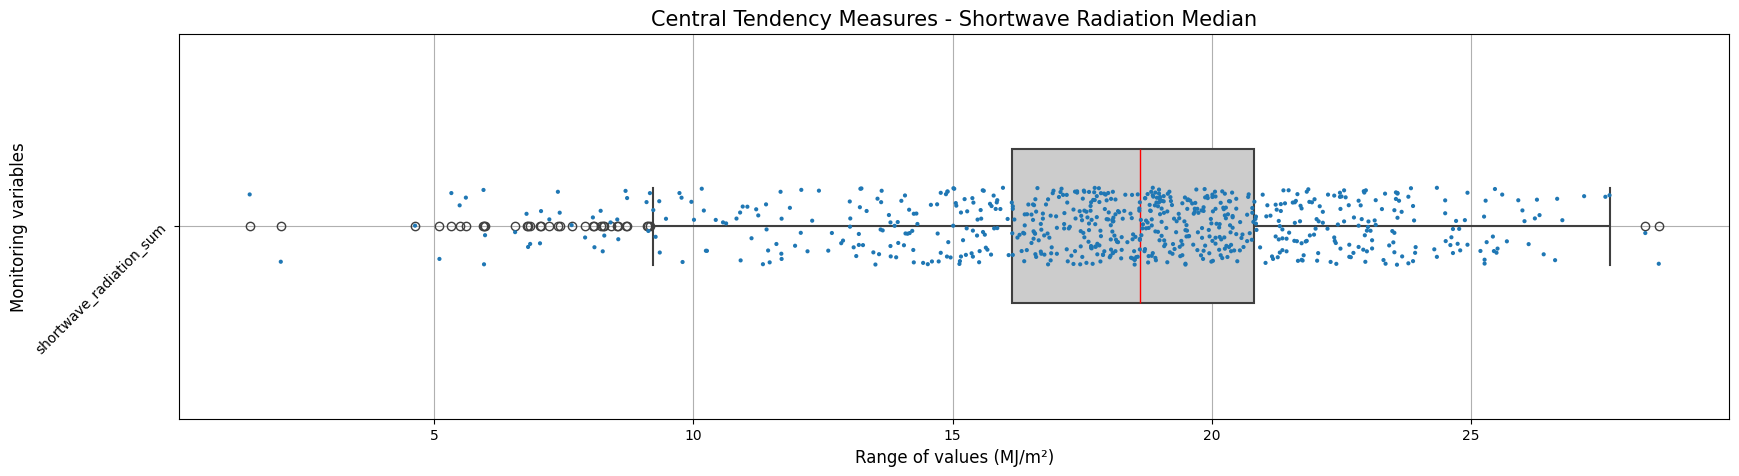

In [71]:
generate_bsplot(
    dataTable=_data[['shortwave_radiation_sum']],
    title="Central Tendency Measures - Shortwave Radiation Median",
    xlabel="MJ/m²"
    )

> Evapotranspiration

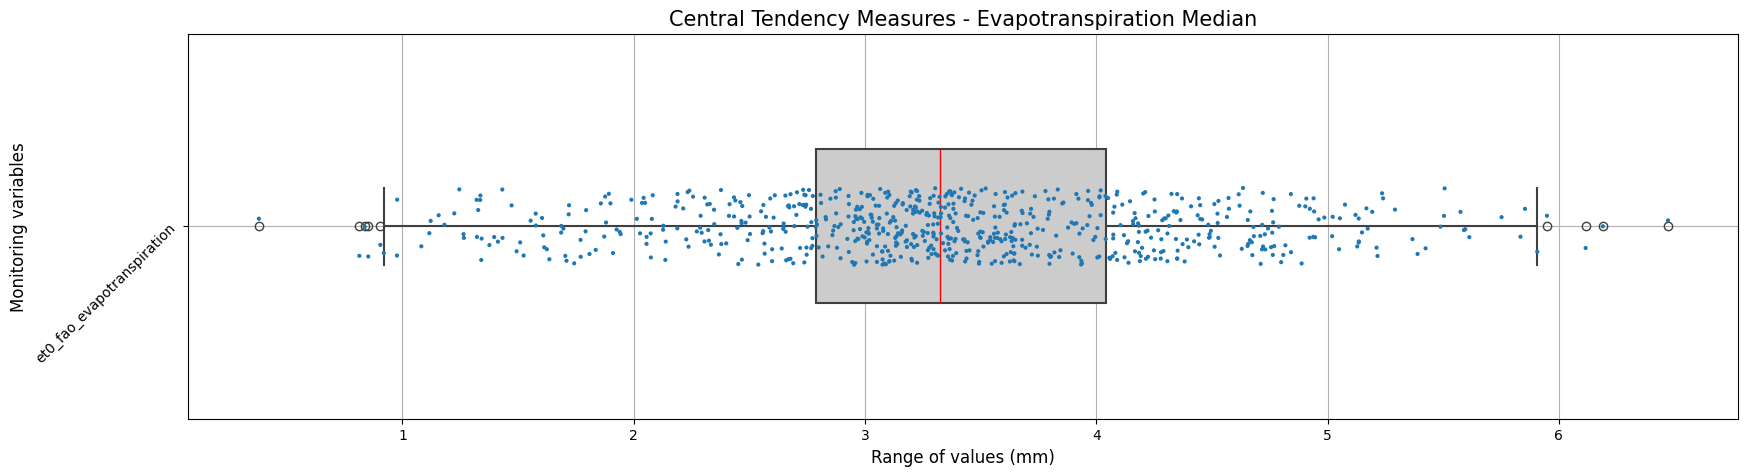

In [72]:
generate_bsplot(
    dataTable=_data[['et0_fao_evapotranspiration']],
    title="Central Tendency Measures - Evapotranspiration Median",
    xlabel="mm"
    )

# Data analysis - Dispersion Measures

## Variance

In [73]:
_data = df.groupby(['date']).var()
display(_data)

temperature_2m_max  temperature_2m_min  temperature_2m_mean  \
date                                                                      
2000-06-17                 NaN                 NaN                  NaN   
2000-07-01          163.321859          155.385552           158.201702   
2000-07-02          168.539387          145.226508           156.449814   
2000-07-03          123.957706          116.881623           114.605629   
2000-07-04          140.559845          113.528067           124.349530   
...                        ...                 ...                  ...   
2015-09-26           84.202129           86.303627            84.714554   
2015-09-27           80.355996           86.578073            80.610454   
2015-09-28           93.818588           66.778630            79.322482   
2015-09-29           81.722380           75.031411            76.481447   
2015-09-30           78.673974           84.873841            78.588052   

            apparent_temperature_max  apparent_temperature_min  \
date                                                             
2000-06-17                       NaN                       NaN   
2000-07-01                206.022999                207.652114   
2000-07-02                207.973911                175.885406   
2000-07-03                150.776467                136.117456   
2000-07-04                195.102264                140.953707   
...                              ...                       ...   
2015-09-26                130.809637                119.645419   
2015-09-27                113.935096                111.820281   
2015-09-28                125.357671                 86.583479   
2015-09-29                111.813372                 93.220813   
2015-09-30                107.984948                105.138117   

            apparent_temperature_mean  precipitation_sum   rain_sum  \
date                                                                  
2000-06-17                        NaN                NaN        NaN   
2000-07-01                 204.797435          18.723331  18.723331   
2000-07-02                 201.816176          38.389999  38.389999   
2000-07-03                 136.832613          33.023330  33.023330   
2000-07-04                 161.515972           0.275833   0.275833   
...                               ...                ...        ...   
2015-09-26                 126.293958          32.849902  32.118318   
2015-09-27                 114.757028          46.351828  46.351828   
2015-09-28                 113.580272          17.414749  16.919003   
2015-09-29                 105.557722          16.532897  16.532897   
2015-09-30                 105.581153          30.790573  30.649623   

            snowfall_sum  precipitation_hours  wind_speed_10m_max  \
date                                                                
2000-06-17           NaN                  NaN                 NaN   
2000-07-01      0.000000            68.666667           95.281079   
2000-07-02      0.000000            39.000000          178.416126   
2000-07-03      0.000000            45.583333           57.578182   
2000-07-04      0.000000             8.000000            6.896005   
...                  ...                  ...                 ...   
2015-09-26      0.080772            72.875943            3.879102   
2015-09-27      0.000000            54.996606            5.677932   
2015-09-28      0.018358            45.702489            3.636062   
2015-09-29      0.000000            27.076923            4.892474   
2015-09-30      0.042105            49.047888            7.635040   

            wind_gusts_10m_max  wind_direction_10m_dominant  \
date                                                          
2000-06-17                 NaN                          NaN   
2000-07-01          259.934445                 32386.199752   
2000-07-02          777.891492                 30480.076443   
2000-07-03          129.459591          

### Data visualization with processing

> Temperature

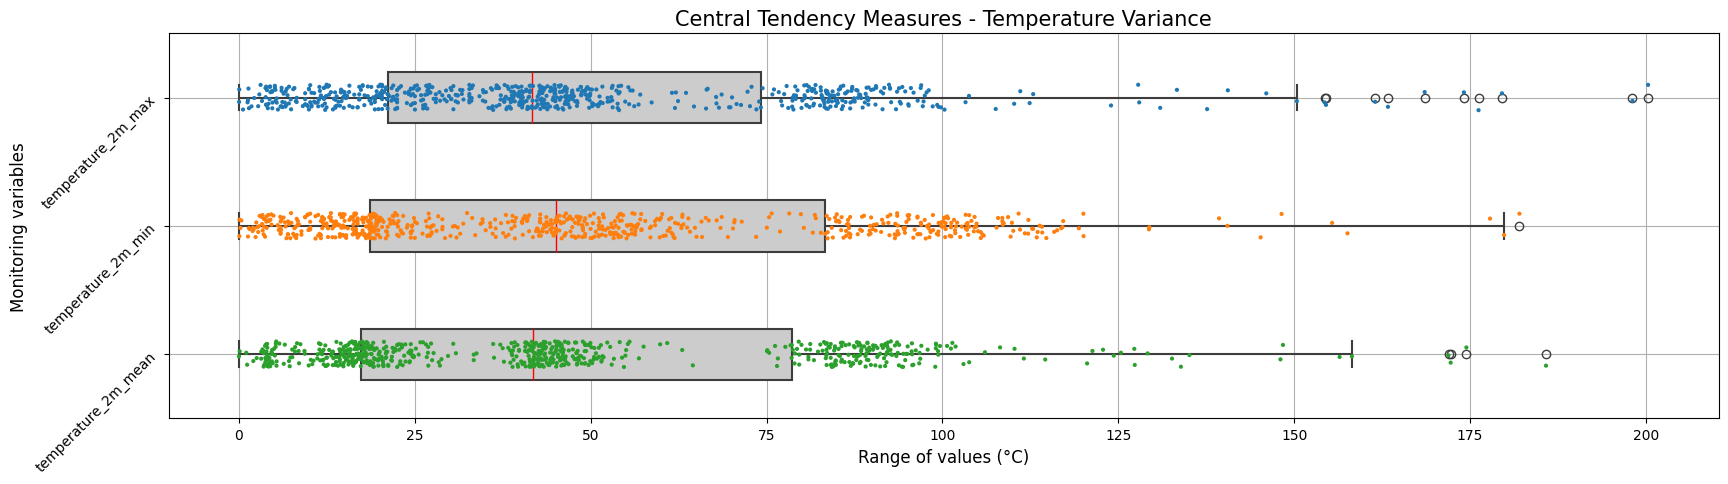

In [74]:
generate_bsplot(
    dataTable=_data[['temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean']],
    title="Central Tendency Measures - Temperature Variance",
    xlabel="°C"
    )

> Apparent Temperature

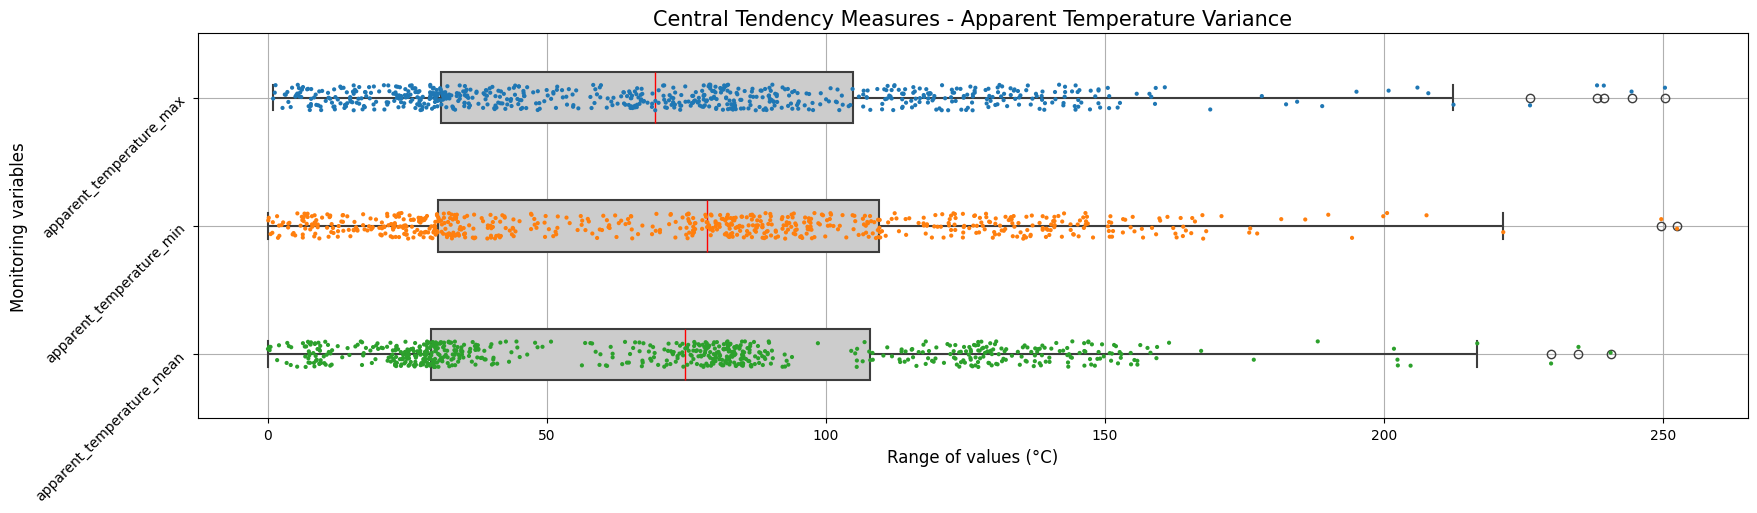

In [75]:
generate_bsplot(
    dataTable=_data[['apparent_temperature_max', 'apparent_temperature_min', 'apparent_temperature_mean']],
    title="Central Tendency Measures - Apparent Temperature Variance",
    xlabel="°C"
    )

> Precipitation and rain

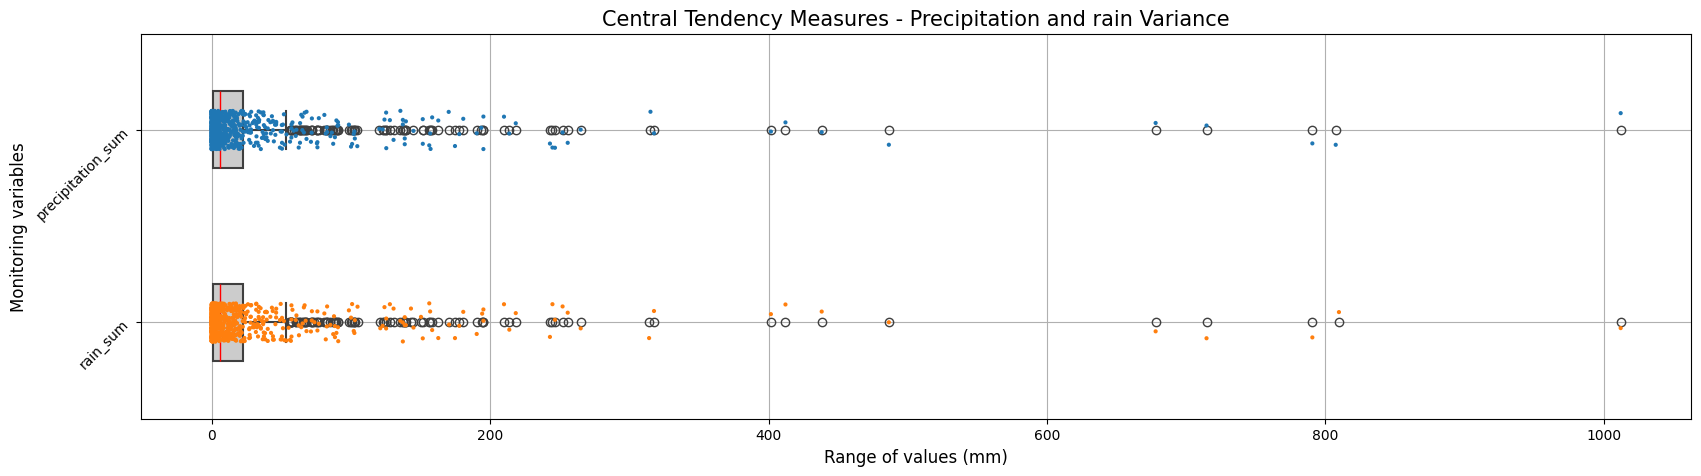

In [76]:
generate_bsplot(
    dataTable=_data[['precipitation_sum', 'rain_sum']],
    title="Central Tendency Measures - Precipitation and rain Variance",
    xlabel="mm"
    )

> Snowfall

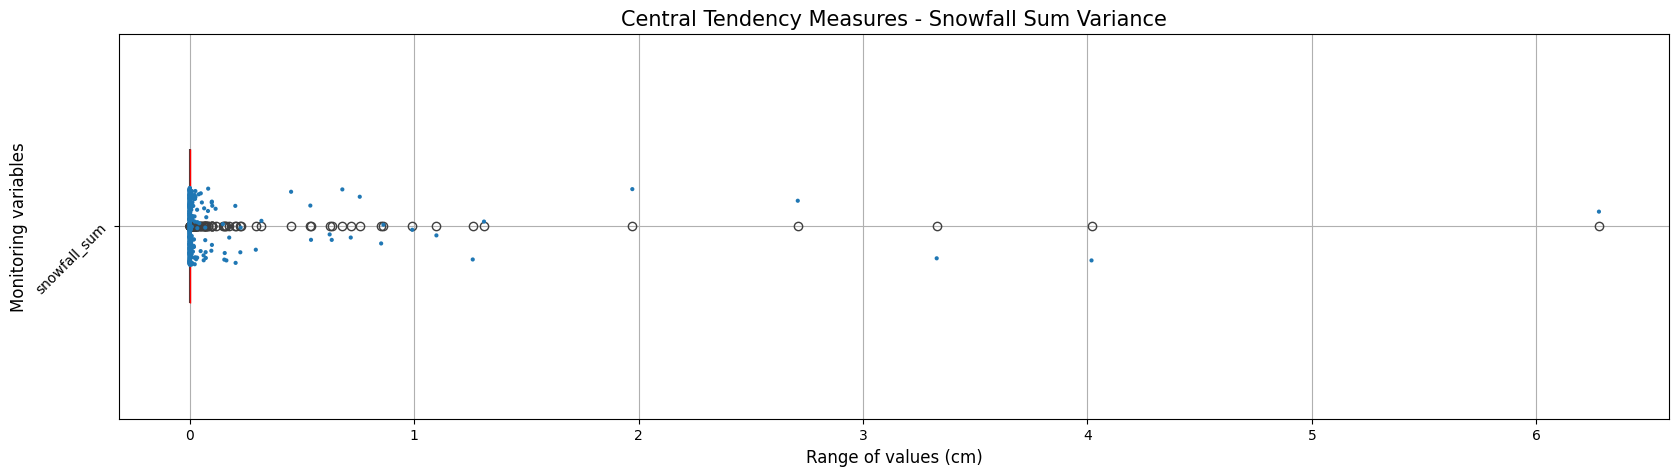

In [77]:
generate_bsplot(
    dataTable=_data[['snowfall_sum']],
    title="Central Tendency Measures - Snowfall Sum Variance",
    xlabel="cm"
    )

> Precipitation

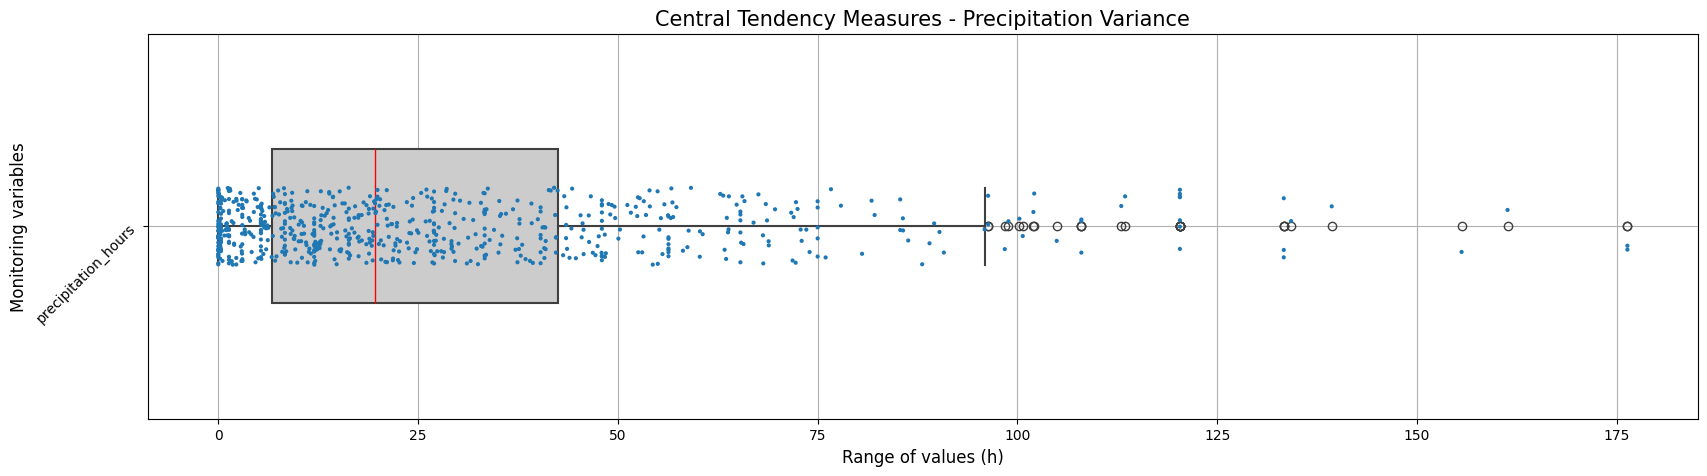

In [78]:
generate_bsplot(
    dataTable=_data[['precipitation_hours']],
    title="Central Tendency Measures - Precipitation Variance",
    xlabel="h"
    )

> Wind speed 10m

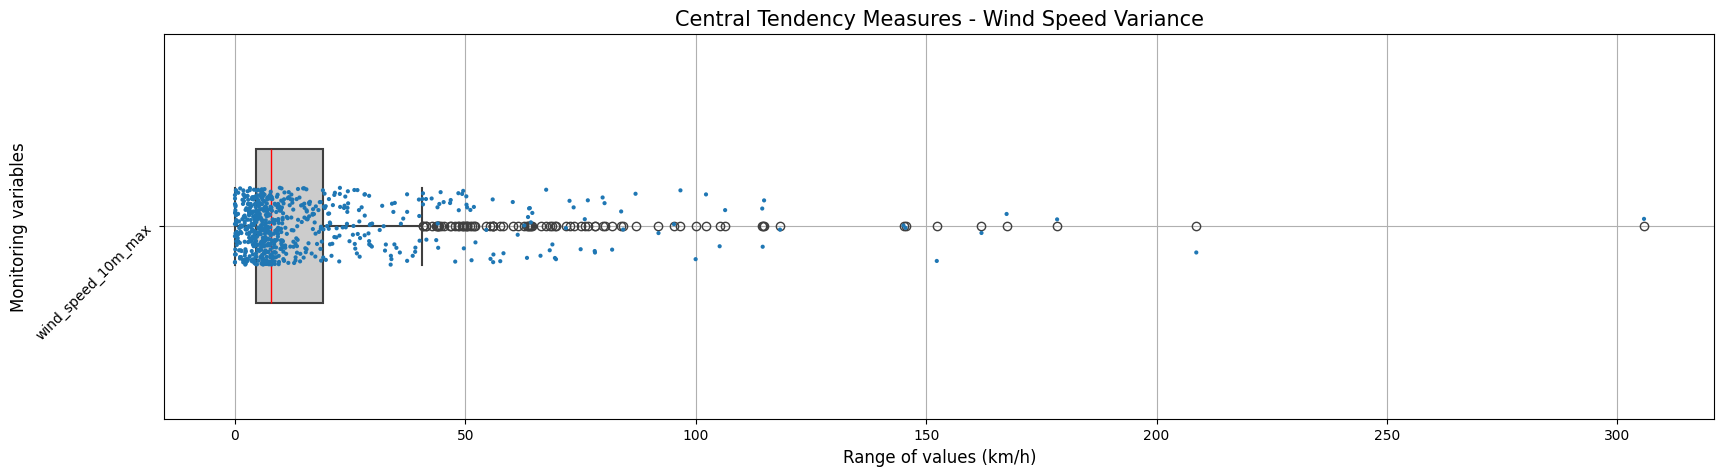

In [79]:
generate_bsplot(
    dataTable=_data[['wind_speed_10m_max']],
    title="Central Tendency Measures - Wind Speed Variance",
    xlabel="km/h"
    )

> Wind direction 10m

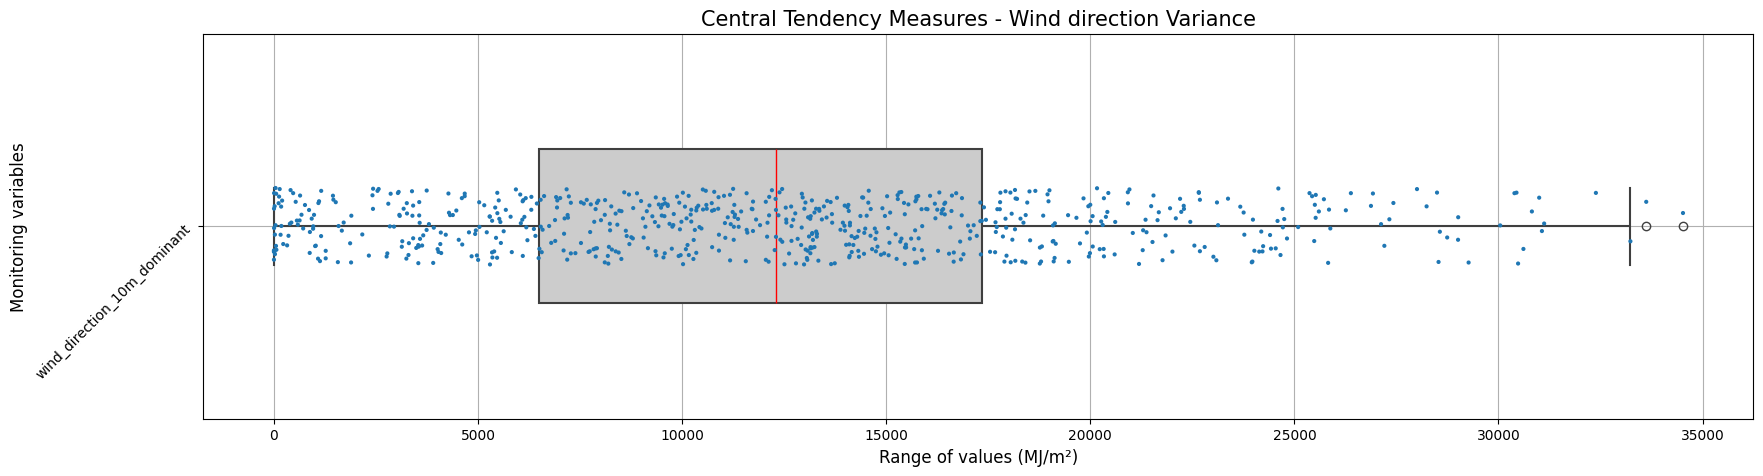

In [80]:
generate_bsplot(
    dataTable=_data[['wind_direction_10m_dominant']],
    title="Central Tendency Measures - Wind direction Variance",
    xlabel="MJ/m²"
    )

> Shortwave radiation

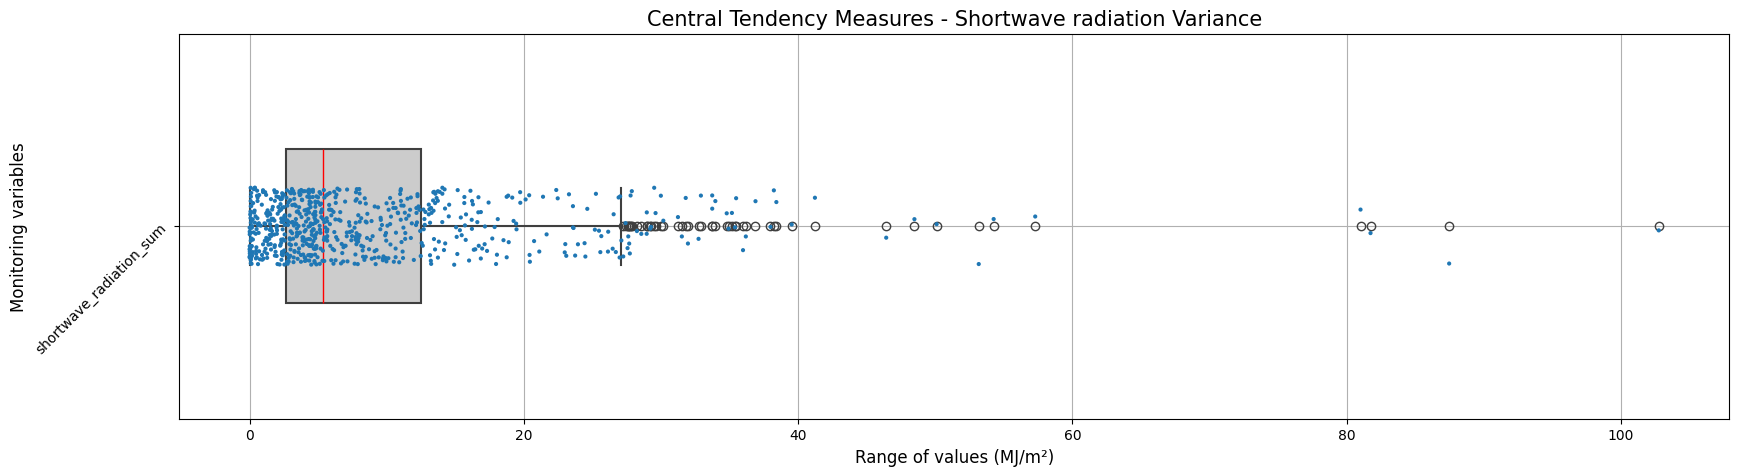

In [81]:
generate_bsplot(
    dataTable=_data[['shortwave_radiation_sum']],
    title="Central Tendency Measures - Shortwave radiation Variance",
    xlabel="MJ/m²"
    )

> Evapotranspiration

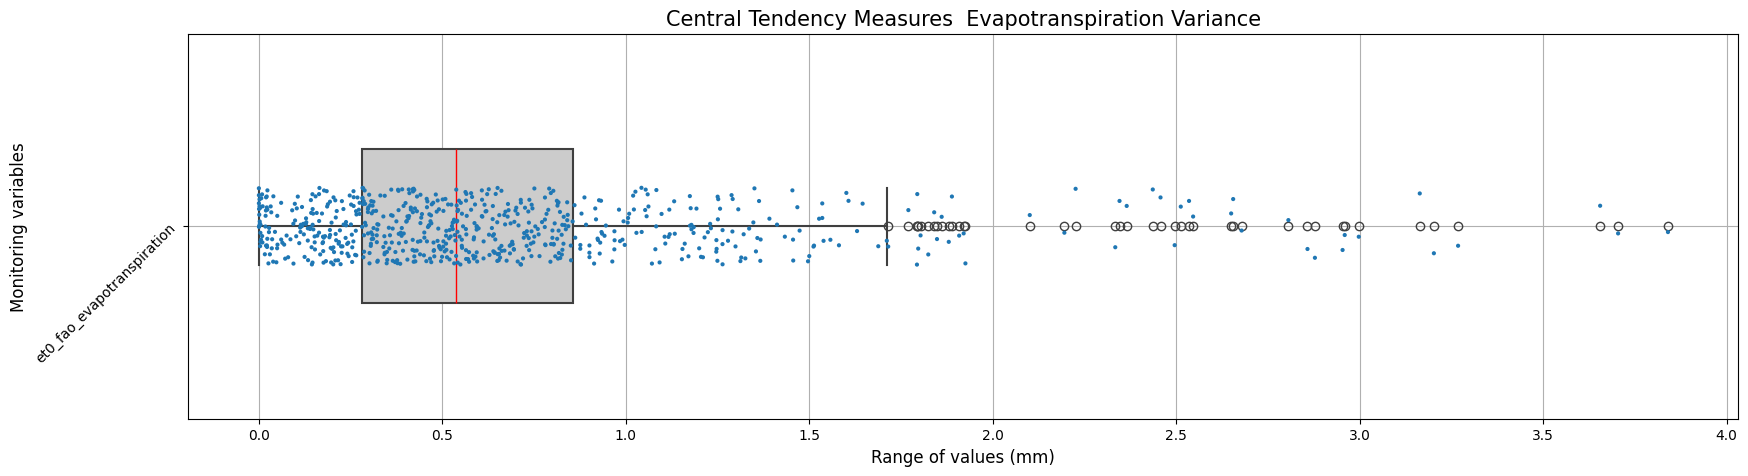

In [82]:
generate_bsplot(
    dataTable=_data[['et0_fao_evapotranspiration']],
    title="Central Tendency Measures  Evapotranspiration Variance",
    xlabel="mm"
    )

## Standard Deviation

In [83]:
_data = df.groupby(['date']).std(ddof=0)
display(_data)

temperature_2m_max  temperature_2m_min  temperature_2m_mean  \
date                                                                      
2000-06-17            0.000000            0.000000             0.000000   
2000-07-01           11.067583           10.795331            10.892717   
2000-07-02           11.242977           10.436469            10.832237   
2000-07-03            9.642006            9.362757             9.271150   
2000-07-04           10.267419            9.227462             9.657233   
...                        ...                 ...                  ...   
2015-09-26            9.087511            9.200214             9.115121   
2015-09-27            8.877538            9.214831             8.891583   
2015-09-28            9.592413            8.092863             8.820264   
2015-09-29            8.952698            8.578374             8.660869   
2015-09-30            8.784134            9.123686             8.779336   

            apparent_temperature_max  apparent_temperature_min  \
date                                                             
2000-06-17                  0.000000                  0.000000   
2000-07-01                 12.430497                 12.479547   
2000-07-02                 12.489213                 11.485384   
2000-07-03                 10.634019                 10.103865   
2000-07-04                 12.096557                 10.281794   
...                              ...                       ...   
2015-09-26                 11.326697                 10.832569   
2015-09-27                 10.570905                 10.472339   
2015-09-28                 11.088144                  9.215119   
2015-09-29                 10.472016                  9.561805   
2015-09-30                 10.291177                 10.154616   

            apparent_temperature_mean  precipitation_sum  rain_sum  \
date                                                                 
2000-06-17                   0.000000           0.000000  0.000000   
2000-07-01                  12.393469           3.747332  3.747332   
2000-07-02                  12.302932           5.365864  5.365864   
2000-07-03                  10.130373           4.976695  4.976695   
2000-07-04                  11.006225           0.454835  0.454835   
...                               ...                ...       ...   
2015-09-26                  11.129476           5.676105  5.612545   
2015-09-27                  10.608966           6.742436  6.742436   
2015-09-28                  10.554432           4.132778  4.073529   
2015-09-29                  10.174859           4.026780  4.026780   
2015-09-30                  10.175989           5.495311  5.482719   

            snowfall_sum  precipitation_hours  wind_speed_10m_max  \
date                                                                
2000-06-17      0.000000             0.000000            0.000000   
2000-07-01      0.000000             7.176350            8.453450   
2000-07-02      0.000000             5.408327           11.567718   
2000-07-03      0.000000             5.847008            6.571426   
2000-07-04      0.000000             2.449490            2.274204   
...                  ...                  ...                 ...   
2015-09-26      0.281459             8.454258            1.950514   
2015-09-27      0.000000             7.344316            2.359818   
2015-09-28      0.134184             6.695043            1.888422   
2015-09-29      0.000000             5.153272            2.190522   
2015-09-30      0.203211             6.935752            2.736460   

            wind_gusts_10m_max  wind_direction_10m_dominant  \
date                                                          
2000-06-17            0.000000                     0.000000   
2000-07-01           13.962480                   155.851371   
2000-07-02           24.154060                   151.195428   
2000-07-03            9.853664                   100.

### Data visualization with processing

> Temperature

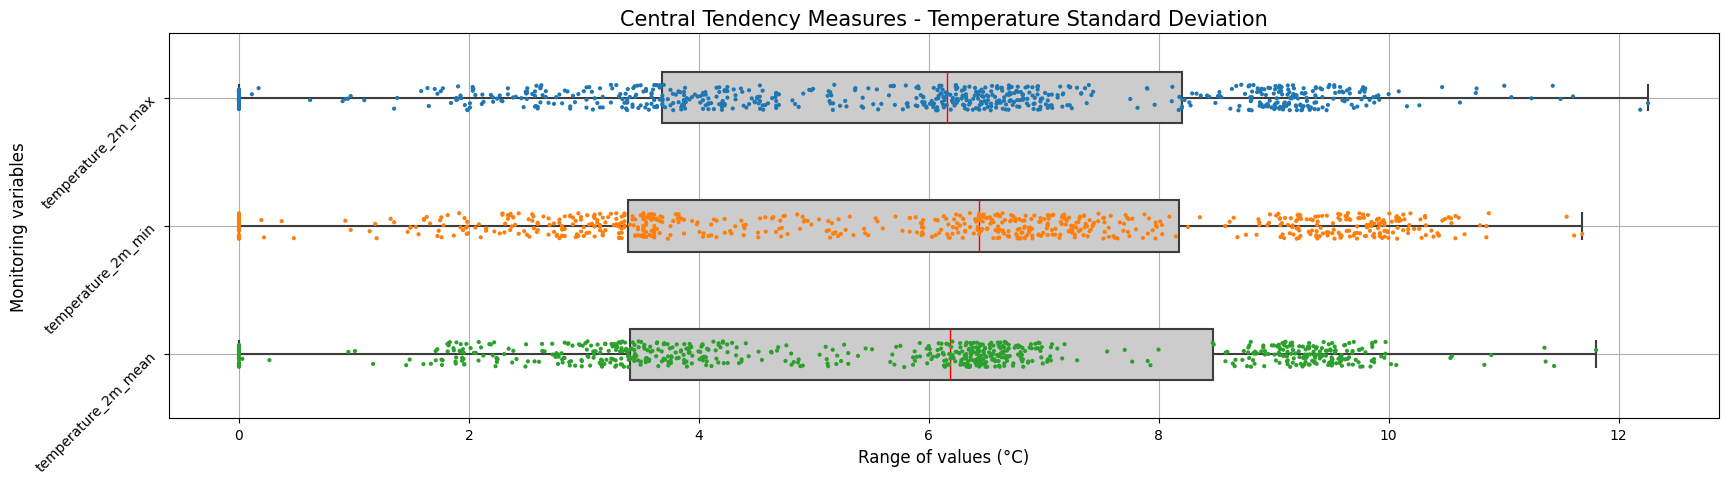

In [84]:
generate_bsplot(
    dataTable=_data[['temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean']],
    title="Central Tendency Measures - Temperature Standard Deviation",
    xlabel="°C"
    )

> Apparent Temperature

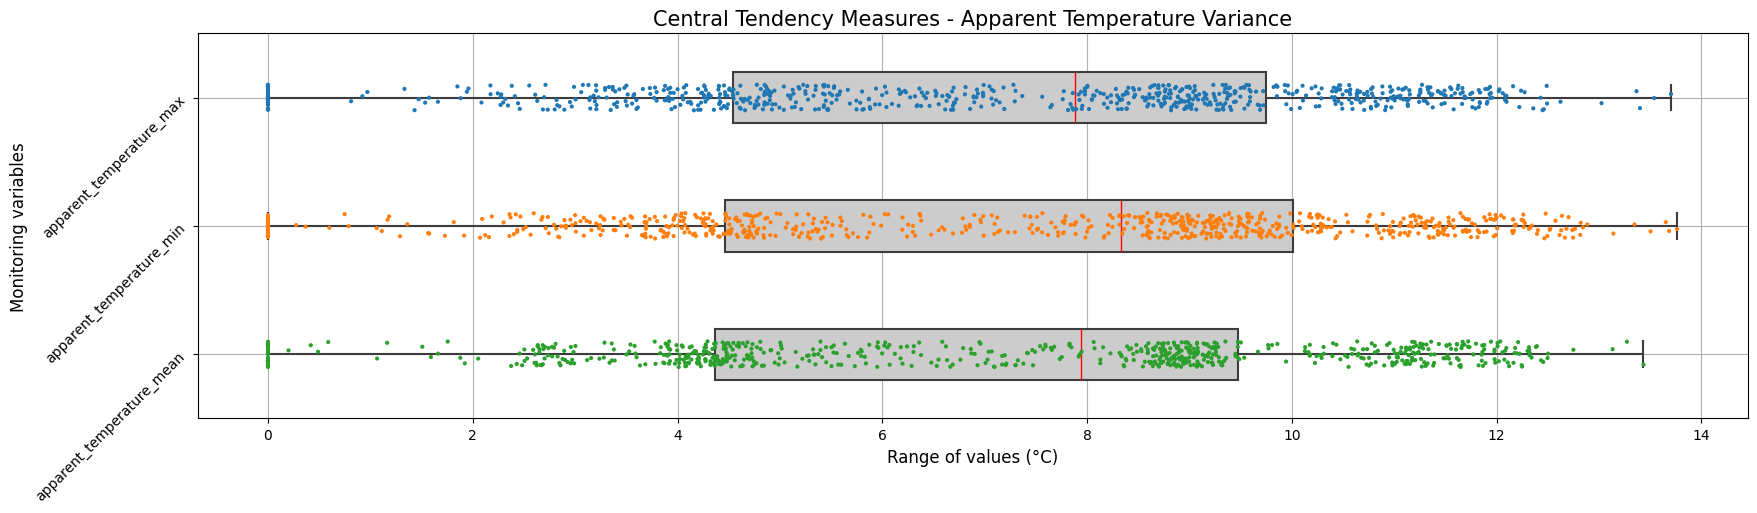

In [85]:
generate_bsplot(
    dataTable=_data[['apparent_temperature_max', 'apparent_temperature_min', 'apparent_temperature_mean']],
    title="Central Tendency Measures - Apparent Temperature Variance",
    xlabel="°C"
    )

> Precipitation and rain

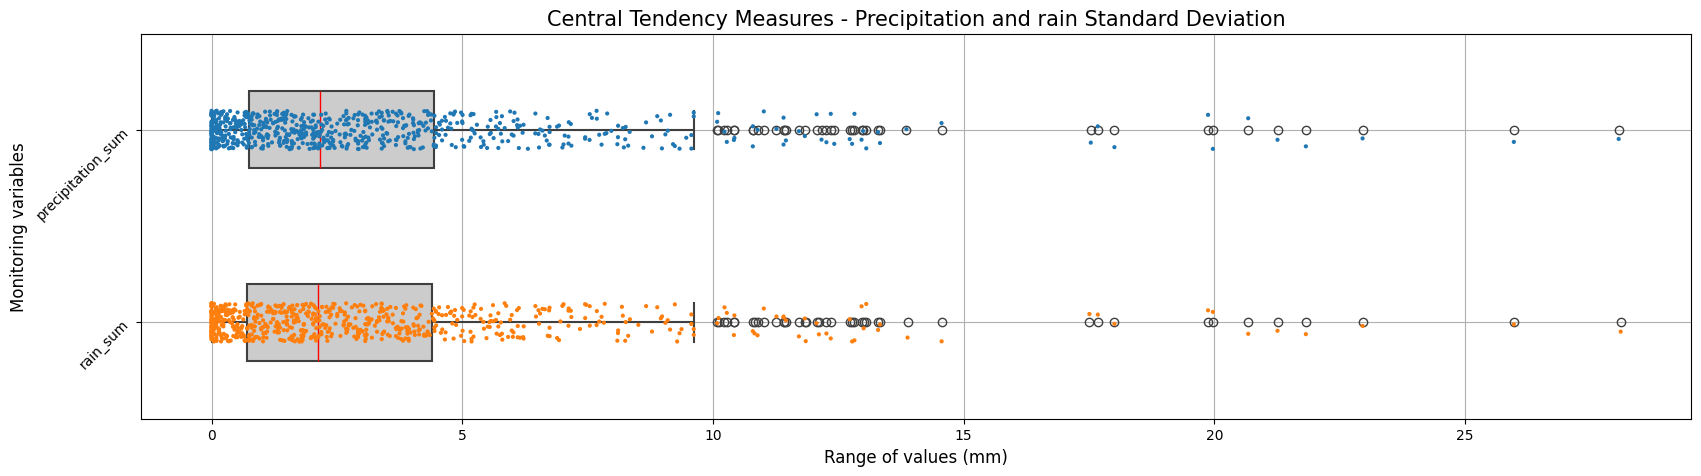

In [86]:
generate_bsplot(
    dataTable=_data[['precipitation_sum', 'rain_sum']],
    title="Central Tendency Measures - Precipitation and rain Standard Deviation",
    xlabel="mm"
    )

> Snowfall

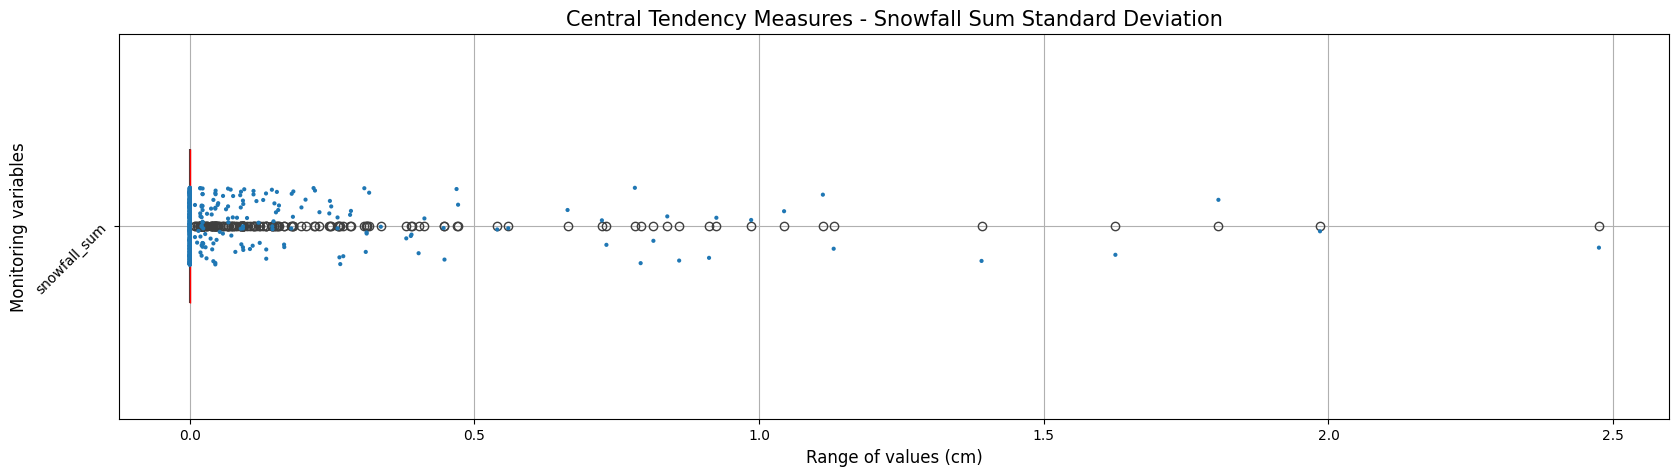

In [87]:
generate_bsplot(
    dataTable=_data[['snowfall_sum']],
    title="Central Tendency Measures - Snowfall Sum Standard Deviation",
    xlabel="cm"
    )

> Precipitation

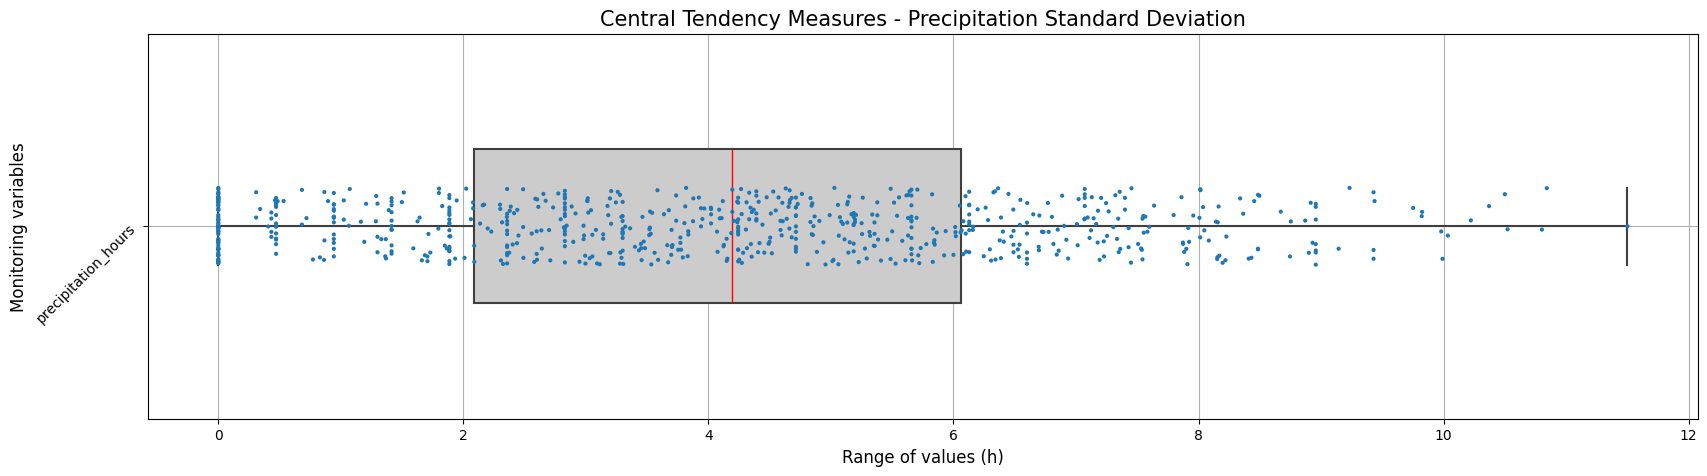

In [88]:
generate_bsplot(
    dataTable=_data[['precipitation_hours']],
    title="Central Tendency Measures - Precipitation Standard Deviation",
    xlabel="h"
    )

> Wind speed 10m

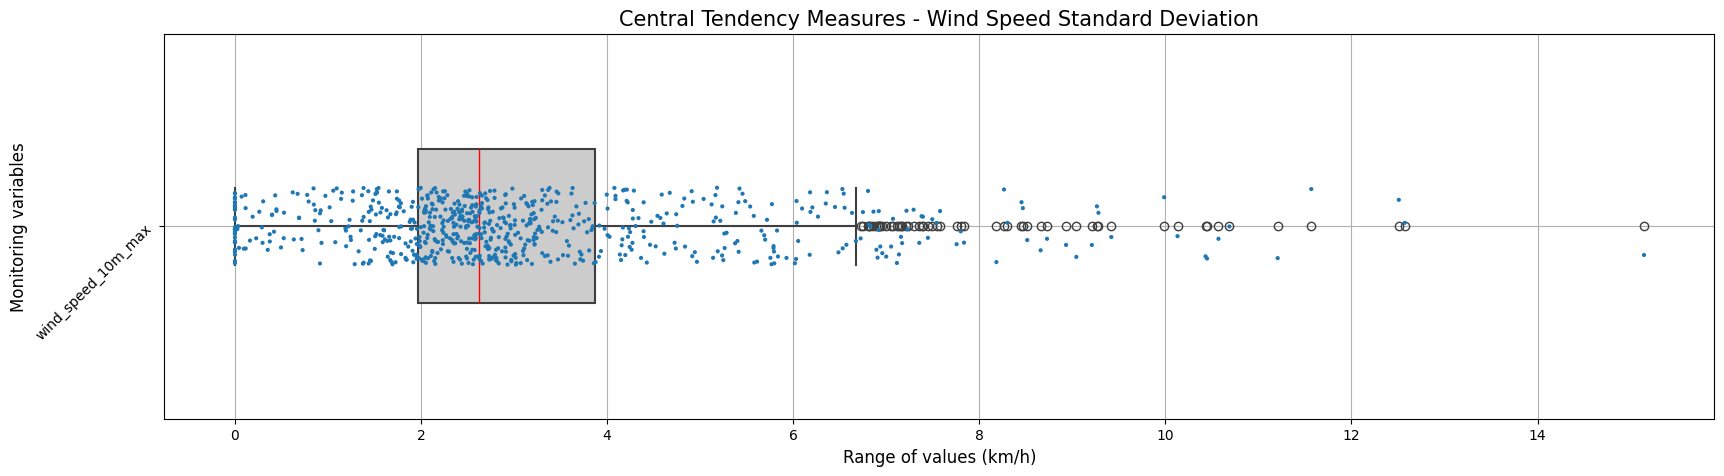

In [89]:
generate_bsplot(
    dataTable=_data[['wind_speed_10m_max']],
    title="Central Tendency Measures - Wind Speed Standard Deviation",
    xlabel="km/h"
    )

> Wind direction 10m

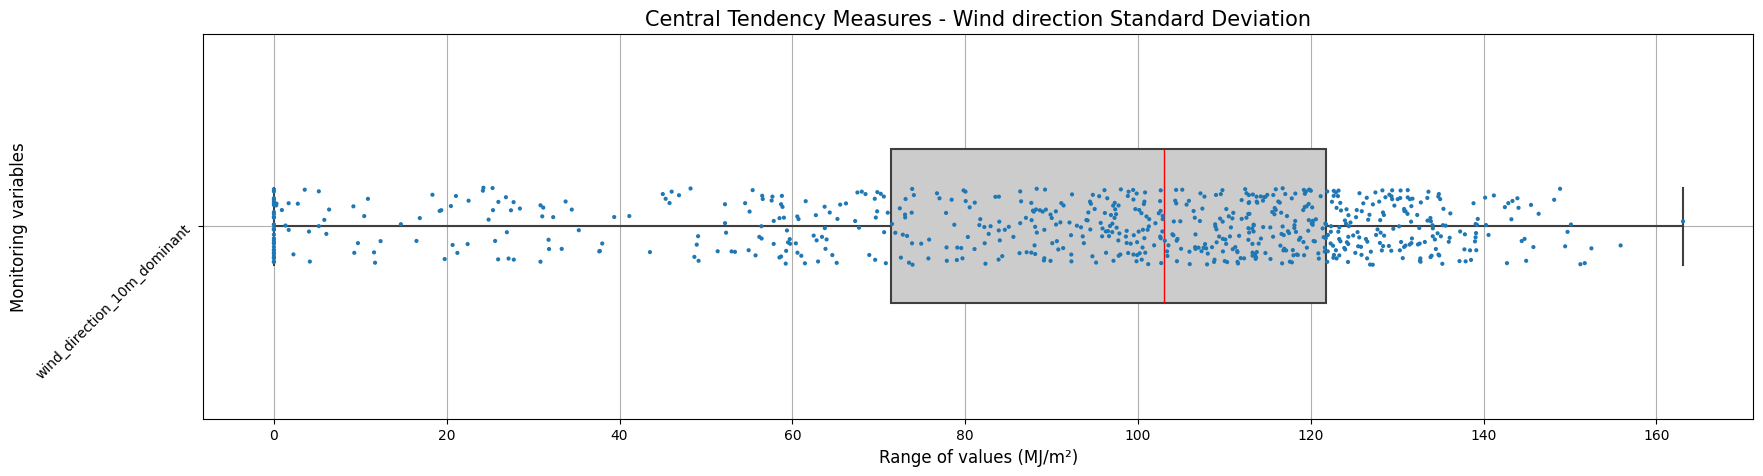

In [90]:
generate_bsplot(
    dataTable=_data[['wind_direction_10m_dominant']],
    title="Central Tendency Measures - Wind direction Standard Deviation",
    xlabel="MJ/m²"
    )

> Shortwave radiation

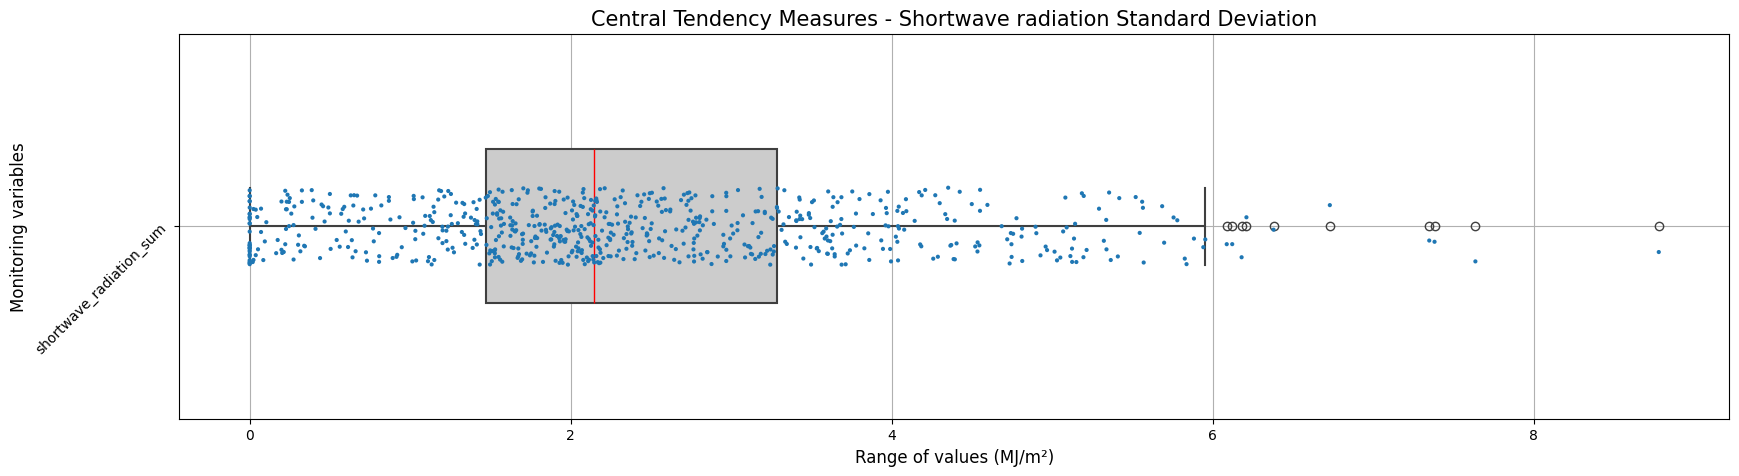

In [91]:
generate_bsplot(
    dataTable=_data[['shortwave_radiation_sum']],
    title="Central Tendency Measures - Shortwave radiation Standard Deviation",
    xlabel="MJ/m²"
    )

> Evapotranspiration

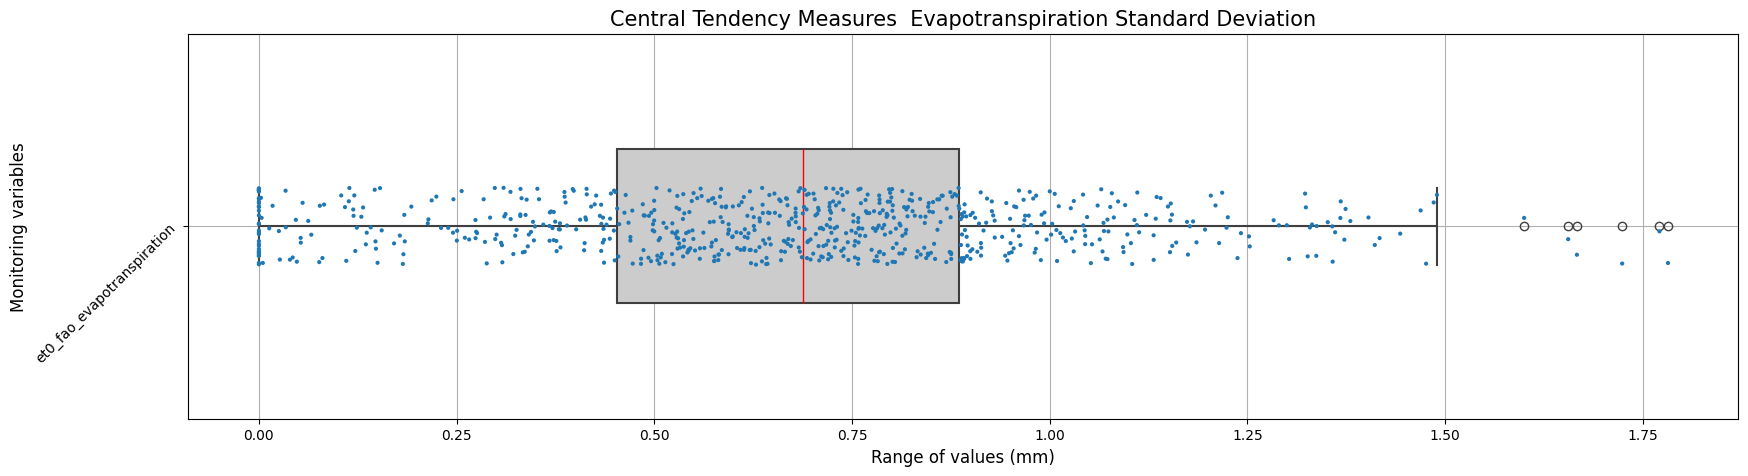

In [92]:
generate_bsplot(
    dataTable=_data[['et0_fao_evapotranspiration']],
    title="Central Tendency Measures  Evapotranspiration Standard Deviation",
    xlabel="mm"
    )

## Covariance

In [93]:
_data = df.groupby(['date']).mean().cov()
display(_data)

temperature_2m_max  temperature_2m_min  \
temperature_2m_max                    27.302436           26.269580   
temperature_2m_min                    26.269580           31.103391   
temperature_2m_mean                   26.419569           28.267504   
apparent_temperature_max              36.409198           37.450026   
apparent_temperature_min              34.444217           41.343610   
apparent_temperature_mean             34.939870           38.900072   
precipitation_sum                      3.075881           10.264356   
rain_sum                               3.173794           10.338072   
snowfall_sum                          -0.071538           -0.054237   
precipitation_hours                    1.224249            9.429192   
wind_speed_10m_max                    -3.697779           -5.916340   
wind_gusts_10m_max                     0.372920            2.428691   
wind_direction_10m_dominant           51.243905           44.512388   
shortwave_radiation_sum               10.124447            4.971157   
et0_fao_evapotranspiration             3.072088            1.940855   

                             temperature_2m_mean  apparent_temperature_max  \
temperature_2m_max                     26.419569                 36.409198   
temperature_2m_min                     28.267504                 37.450026   
temperature_2m_mean                    27.048610                 36.419757   
apparent_temperature_max               36.419757                 50.870845   
apparent_temperature_min               37.331239                 50.044199   
apparent_temperature_mean              36.489440                 49.731431   
precipitation_sum                       6.476913                  7.690131   
rain_sum                                6.560327                  7.826465   
snowfall_sum                           -0.061129                 -0.099808   
precipitation_hours                     5.138374                  6.049270   
wind_speed_10m_max                     -5.030442                 -9.447141   
wind_gusts_10m_max                      0.996083                 -2.936089   
wind_direction_10m_dominant            45.796196                 75.091273   
shortwave_radiation_sum                 7.562249                 12.872674   
et0_fao_evapotranspiration              2.499634                  3.731686   

                             apparent_temperature_min  \
temperature_2m_max                          34.444217   
temperature_2m_min                          41.343610   
temperature_2m_mean                         37.331239   
apparent_temperature_max                    50.044199   
apparent_temperature_min                    55.614973   
apparent_temperature_mean                   52.150506   
precipitation_sum                           14.657208   
rain_sum                                    14.764688   
snowfall_sum                                -0.079038   
precipitation_hours                         13.990335   
wind_speed_10m_max                         -10.136218   
wind_gusts_10m_max                           0.750577   
wind_direction_10m_dominant                 69.676198   
shortwave_radiation_sum                      6.645698   
et0_fao_evapotranspiration                   2.432906   

                             apparent_temperature_mean  precipitation_sum  \
temperature_2m_max                           34.939870           3.075881   
temperature_2m_min                           38.900072          10.264356   
temperature_2m_mean                          36.489440           6.476913   
apparent_temperature_max                     49.731431           7.690131   
apparent_temperature_min                     52.150506          14.657208   
apparent_temperature_mean                    50.401701          11.045543   
precipitation_sum                            11.045543          22.939059   
rain_sum                                     11.163030          22.910031   
snowfall_sum                         

### Data visualization with processing

> Temperature

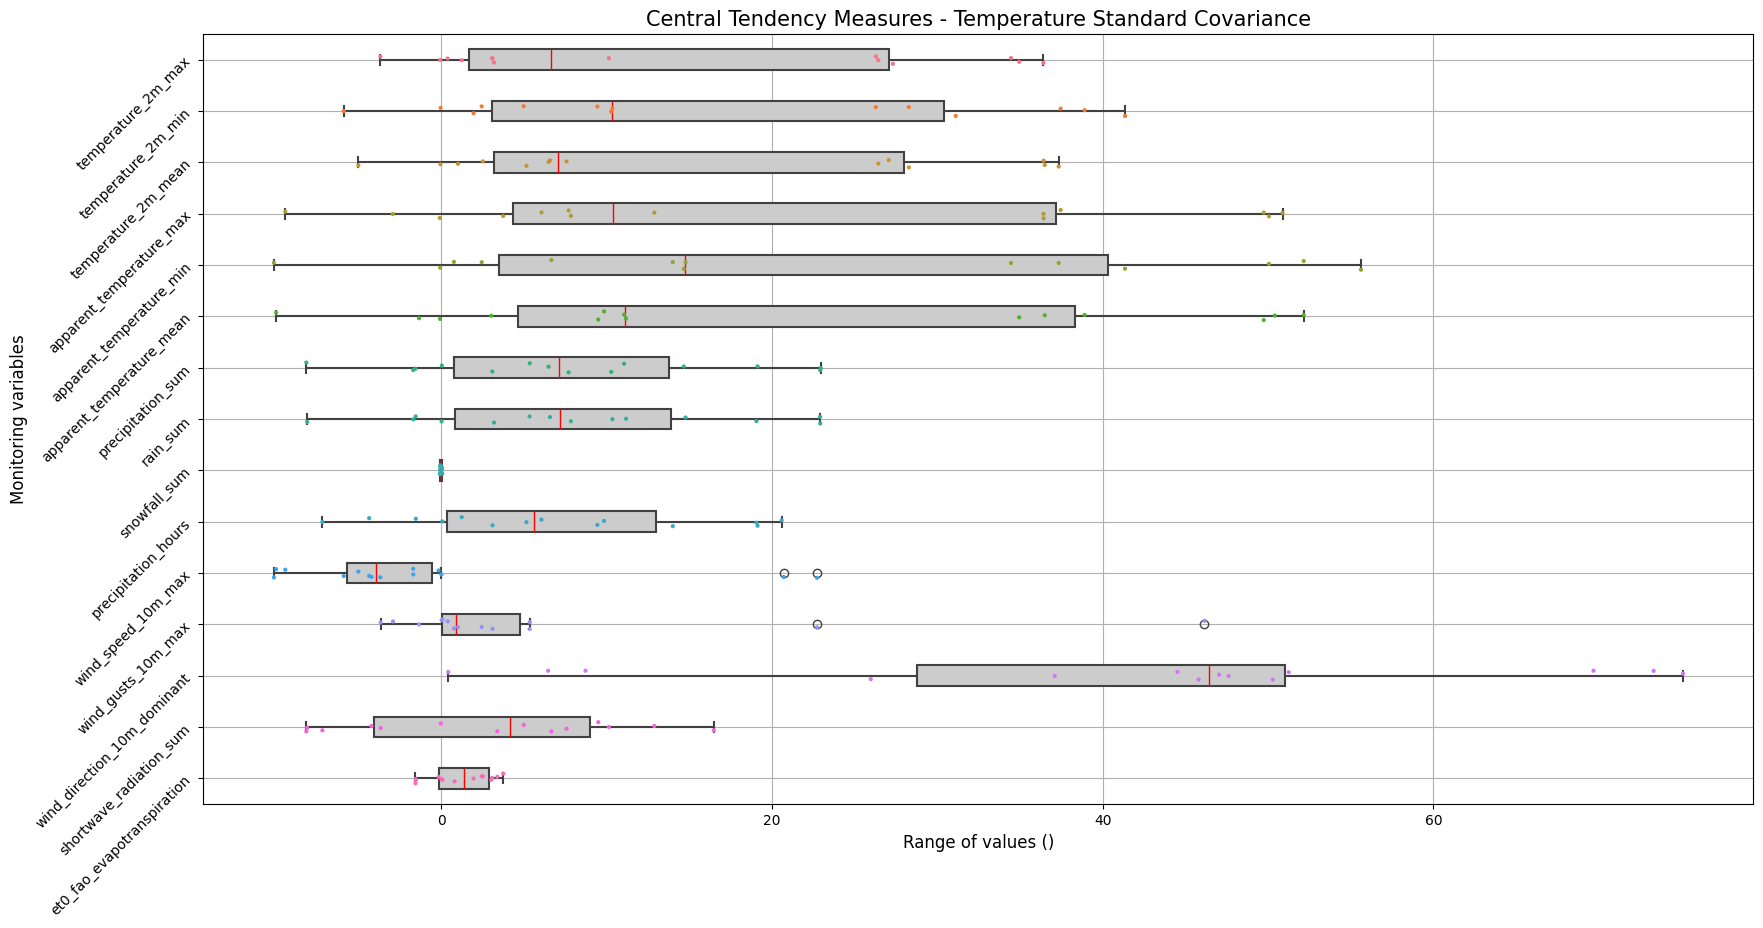

In [94]:
generate_bsplot(
    dataTable=_data.query("wind_direction_10m_dominant < 2500"),
    title="Central Tendency Measures - Temperature Standard Covariance",
    xlabel="",
    width=20,
    heigth=10
    )

##Correlation

In [95]:
_data = df.groupby(['date']).mean().corr()
display(_data)

temperature_2m_max  temperature_2m_min  \
temperature_2m_max                     1.000000            0.901464   
temperature_2m_min                     0.901464            1.000000   
temperature_2m_mean                    0.972193            0.974566   
apparent_temperature_max               0.976958            0.941486   
apparent_temperature_min               0.883934            0.994051   
apparent_temperature_mean              0.941885            0.982480   
precipitation_sum                      0.122908            0.384273   
rain_sum                               0.126918            0.387331   
snowfall_sum                          -0.128007           -0.090927   
precipitation_hours                    0.051651            0.372721   
wind_speed_10m_max                    -0.155544           -0.233164   
wind_gusts_10m_max                     0.010506            0.064105   
wind_direction_10m_dominant            0.155348            0.126427   
shortwave_radiation_sum                0.477446            0.219638   
et0_fao_evapotranspiration             0.659947            0.390630   

                             temperature_2m_mean  apparent_temperature_max  \
temperature_2m_max                      0.972193                  0.976958   
temperature_2m_min                      0.974566                  0.941486   
temperature_2m_mean                     1.000000                  0.981816   
apparent_temperature_max                0.981816                  1.000000   
apparent_temperature_min                0.962507                  0.940857   
apparent_temperature_mean               0.988262                  0.982141   
precipitation_sum                       0.260021                  0.225119   
rain_sum                                0.263572                  0.229286   
snowfall_sum                           -0.109895                 -0.130836   
precipitation_hours                     0.217804                  0.186974   
wind_speed_10m_max                     -0.212592                 -0.291125   
wind_gusts_10m_max                      0.028193                 -0.060598   
wind_direction_10m_dominant             0.139483                  0.166770   
shortwave_radiation_sum                 0.358288                  0.444722   
et0_fao_evapotranspiration              0.539486                  0.587282   

                             apparent_temperature_min  \
temperature_2m_max                           0.883934   
temperature_2m_min                           0.994051   
temperature_2m_mean                          0.962507   
apparent_temperature_max                     0.940857   
apparent_temperature_min                     1.000000   
apparent_temperature_mean                    0.985009   
precipitation_sum                            0.410362   
rain_sum                                     0.413690   
snowfall_sum                                -0.099092   
precipitation_hours                          0.413567   
wind_speed_10m_max                          -0.298740   
wind_gusts_10m_max                           0.014816   
wind_direction_10m_dominant                  0.147997   
shortwave_radiation_sum                      0.219583   
et0_fao_evapotranspiration                   0.366189   

                             apparent_temperature_mean  precipitation_sum  \
temperature_2m_max                            0.941885           0.122908   
temperature_2m_min                            0.982480           0.384273   
temperature_2m_mean                           0.988262           0.260021   
apparent_temperature_max                      0.982141           0.225119   
apparent_temperature_min                      0.985009           0.410362   
apparent_temperature_mean                     1.000000           0.324845   
precipitation_sum                             0.324845           1.000000   
rain_sum                                      0.328553           0.999503   
snowfall_sum                         

### Data visualization with processing

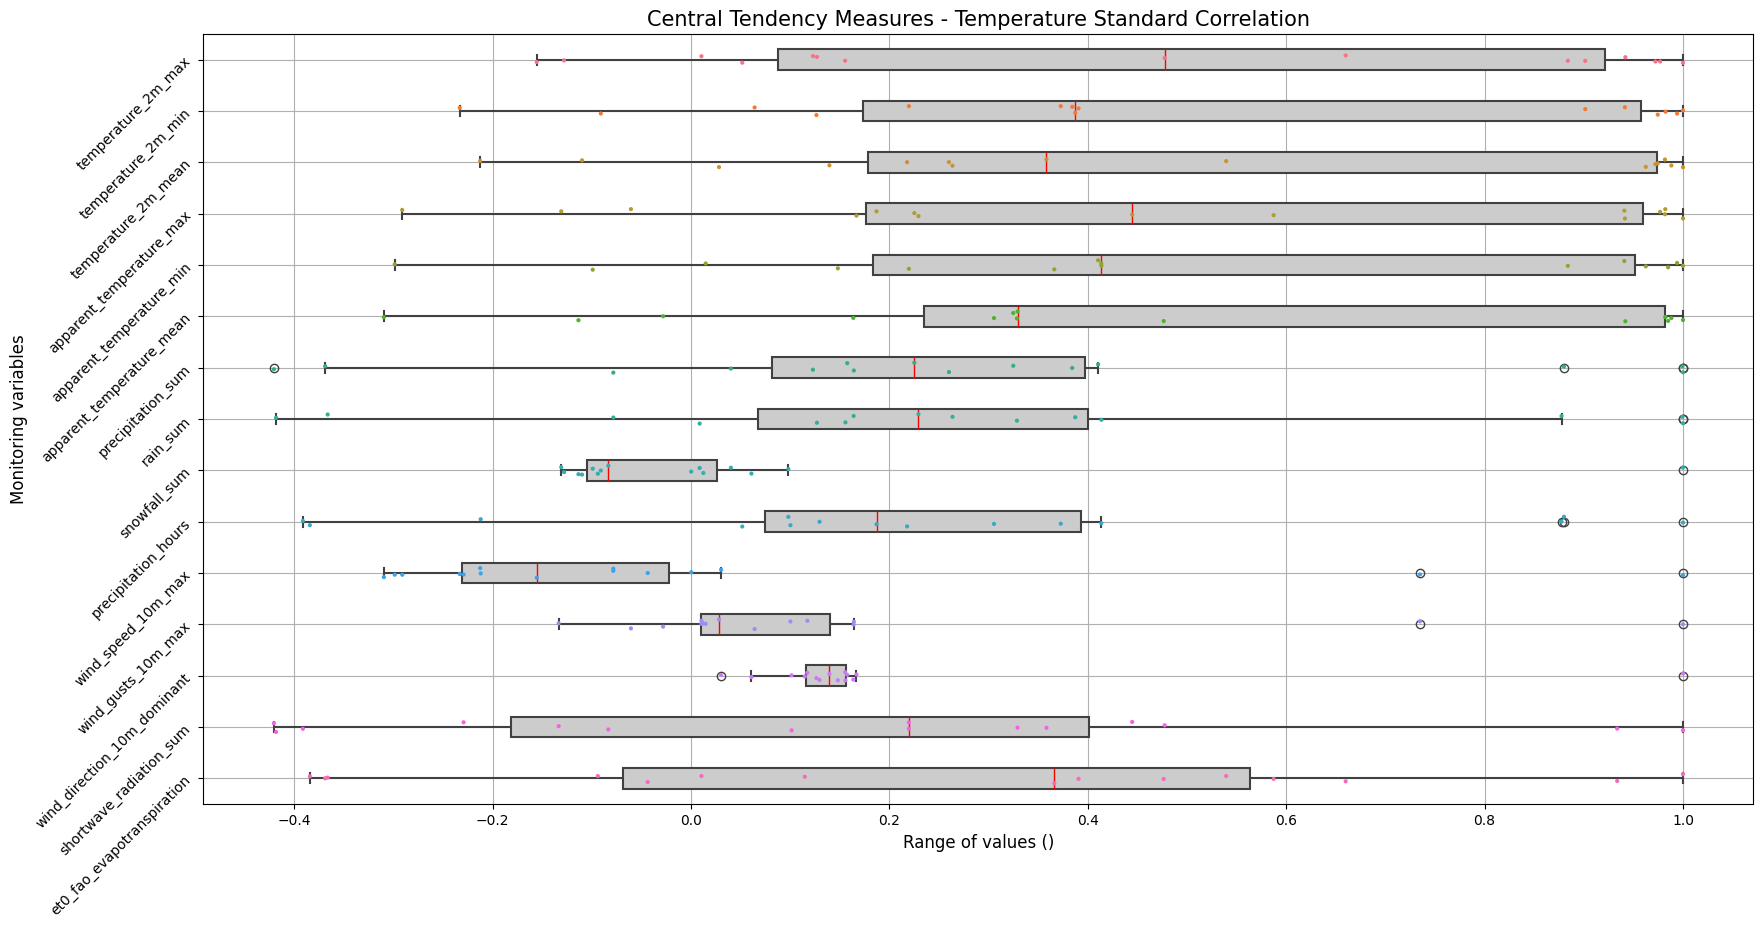

In [96]:
generate_bsplot(
    dataTable=_data,
    title="Central Tendency Measures - Temperature Standard Correlation",
    xlabel="",
    width=20,
    heigth=10
    )